# Market Basket Analysis 
Datascience, Fall 2019
### Team Components
    - Alexandre Rault 1842873
    - Jérémie Huppé 1854753

**Authors**: Rodrigo Randel

## Market Basket Analysis

Market Basket Analysis (MBA) is a data mining analytics technique to uncover associations between products or product grouping. By exploring interesting patterns from an extensive collection of data, MBA aims to understand/reveal customer purchase behaviors based upon the theory that if you purchased a certain set of products, then you are more (or less) likely to buy another group of products. In other words, MBA allows retailers to identify the relationship between the items that customers buy, revealing patterns of items often purchased together.

A widely approach to explore these patterns is by constructing ***association rules*** such as:
- **if** bought *ITEM_1* **then** will buy *ITEM_2* with **confidence** *X*.

These associations do not have to be 1-to-1 rules. They can involve many items. For example, a person in a supermarket may add eggs to his/her cart, then an MBA application may suggest that the person will also buy some bread and/or flour: 
    
+ **if** bought *EGGS* **then** will buy [*BREAD* with confidence *0.2*; *FLOUR* with confidence 0.05].

However, if the person now decides to add flour to his/her cart, the new association rule could be as showing below, suggesting ingredients to make a cake.

+ **if** bought [*EGGS, FLOUR*] **then** will buy [*SUGGAR* with confidence 0.45; BAKING POWDER with confidence 0.12; *BREAD* with confidence *0.03*].


There are many real scenarios where MBA plays a central role in data analysis, such as supermarket transactions, online orders or credit card history. Marketers may use these association rules to allocate correlated products close to each other on store shelves or make online suggestions so that customers buy more items. Some questions that an MBA can usually help retailers to answer are:

    - What items are often purchased together?
    - Given a basket, what items should be suggested?
    - How should items be placed together on the shelves?


### Objective

Your goal in this TP is to develop an MBA algorithm for revealing patterns by creating association rules in a big dataset with more than three millions supermarket transactions. However, mining association rules for large datasets is a very computationally intensive problem, which makes it almost impractical to perform it without a distributed system. Hence, to run your algorithm, you will have access to a distributed cloud computing cluster with hundreds of cores. 

To this end, a **MapReduce** algorithm will be implemented upon the [Apache Spark](http://spark.apache.org) framework, a fast cluster computing system. In a nutshell, Spark is an open source framework designed with a *scale-out* methodology which makes it a very powerful tool for programmers or application developers to perform a massive volume of computations and data processing in distributed environments. Sparks provides high-level APIs that make it easy to build parallel apps without needing to worry about how your code and data are parallelized/distributed thought the computing cluster. Spark does it all for you.
 
The implementation will follow the Market Basket Analysis algorithm presented by Jongwook Woo and Yuhang Xu (2012). The image **workflow.svg** Illustrates the algorithm's workflow, and is to be used for consultation throughout this TP. The blue boxes are the ones where you must implement a method to perform a map or reduce function, and the grey boxes represent their expected output. **All these operations are explained in details in the following sections.** 

<!---
# ![scale=0.5](workflow.svg "Algorithm Workflow")
-->

## 1. Setting up Spark

Spark runs on both Windows and UNIX-like systems (e.g., Linux, Mac OS). It's easy to run locally on one machine — all you need is to have Java installed on your system PATH, or the JAVA_HOME environment variable pointing to a Java installation. It is recommended that you have the **JDK v8** installed in your system. If you haven't, go to [Java's web page](https://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) to download and install a Java Virtual Machine. Remember to set the environment variable JAVA_HOME if your installation does not do it automatically for you. 

The interface between Python and Spark is done through **PySpark**, which can be obtained following the sequence below:

1. First, go to http://spark.apache.org/downloads 
2. Select the newest Spark release and the Pre-built for Apache Hadoop 2.7 package 
3. Click for download **spark-2.4.4-bin-hadoop2.7.tgz** and unzip it in any folder of your preference. 
4. Next, export the following variables to link PYSPARK (Spark's python interface) to your python distribution in yout `~/.bash_profile` file.
```
    - export SPARK_HOME=/path/to/spark-2.4.4-bin-hadoop2.7
    - export PYTHONPATH="$SPARK_HOME/python:$SPARK_HOME/python/lib/py4j-0.10.7-src.zip:$SPARK_HOME/python/lib/pyspark.zip:$PYTHONPATH"
    - export PYSPARK_PYTHON=/path/to/your/python3
```
5. Run `source ~./bash_profile` to effictate the changes and reinitializate this jupyter notebook session.

In [1]:
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
!pip install pyspark

     |████████████████████████████████| 215.7MB 66kB/s 
     |████████████████████████████████| 204kB 41.2MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=26c812c3206086276a808f7f341f6aba361bd9b7eb98be555014bfa7a658ee3e
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


### 1.1 Product Counting Example 

To test your installation and start to get familiarized with Spark, we will follow an example that counts how many times the products of a toy dataset were purchased.

The main entry point to start programming with Spark is the [RDD API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD), an excellent Spark abstraction to work with the MapReduce framework.  RDD is a collection of elements partitioned across the nodes of the cluster that can operate in parallel. In other words, RDD is how Spark keeps your data ready to perform some function (e.g., a map or reduce function) in parallel. **Do not worry if this still sounds confusing, it will be clear once you start implementing**. However, it is part of this TP to study/consult the [Spark python API](https://spark.apache.org/docs/latest/api/python/) and learn how to use it. Some useful functions that the RDD API offers are:

1. **map**: return a new RDD by applying a function to each element of this RDD.
2. **flatMap**: return a new RDD by first applying a function to all elements of this RDD, and then flattening the results. **Should be used when each entry will yield more than one mapped element**
3. **reduce**: reduces the elements of this RDD using the specified commutative and associative binary operator.
4. **reduceByKey**: merge the values for each key using an associative and commutative reduce function
5. **groupByKey**: group the values for each key in the RDD into a single sequence
6. **collect**: return a list that contains all of the elements in this RDD. **Should not be used when working with a lot of data**
7. **sample**: return a sampled subset of this RDD
8. **count**: return the number of elements in this RDD.
9. **filter**: return a new RDD containing only the elements that satisfy a predicate.

In [0]:
from pyspark.sql import SparkSession

def map_to_product(row):
    """
    Map each transaction into a set of KEY-VALUE elements.
    The KEY is the word (product) itself and the VALUE is its number of apparitions.
    """
    products = row.transaction.split(';') # split products from the column transaction
    for p in products:
        yield (p, 1)

def reduce_product_by_key(value1, value2):
    "Reduce the mapped objects to unique words by merging (summing ) their values"
    return value1+value2

# Initializates a object of SparkSession class, main entry point to Spark's funcionalites
spark = SparkSession.builder.getOrCreate()
        
# Read a toy dataset
toy = spark.read.csv('toy.csv', header=True)
print("Toy dataset")
toy.show()

# Obtain a RDD object to call a map function
toy_rdd = toy.rdd
print("Toy dataframe as a RDD object (list of Row objects):\n\t", toy_rdd.collect())

# Map function to identify all products
toy_rdd = toy_rdd.flatMap(map_to_product)
print("\nMapped products:\n\t", toy_rdd.collect())

# Reduce function to merge values of elements that share the same KEY
toy_rdd = toy_rdd.reduceByKey(reduce_product_by_key)
print("\nReduced (merged) products:\n\t", toy_rdd.collect())

print("\nVisualizing as a dataframe:")
toy_rdd.toDF(["product", "count_product"]).show()

Toy dataset
+--------+-----------+
|order_id|transaction|
+--------+-----------+
|       1|      a;b;c|
|       2|      a;b;d|
|       3|        b;c|
|       4|        b;c|
+--------+-----------+

Toy dataframe as a RDD object (list of Row objects):
	 [Row(order_id='1', transaction='a;b;c'), Row(order_id='2', transaction='a;b;d'), Row(order_id='3', transaction='b;c'), Row(order_id='4', transaction='b;c')]

Mapped products:
	 [('a', 1), ('b', 1), ('c', 1), ('a', 1), ('b', 1), ('d', 1), ('b', 1), ('c', 1), ('b', 1), ('c', 1)]

Reduced (merged) products:
	 [('a', 2), ('b', 4), ('c', 3), ('d', 1)]

Visualizing as a dataframe:
+-------+-------------+
|product|count_product|
+-------+-------------+
|      a|            2|
|      b|            4|
|      c|            3|
|      d|            1|
+-------+-------------+



### 1.2 Working the Spark's Dataframe

In the example above, we briefly used a Spark's Dataframe class, but only to obtain an RDD object with ```toy.rdd``` and to print the data as a structured table with the ```show()``` function. However, [Dataframe](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#) is a big part of the current Spark release and is built upon the RDD API. It is a distributed collection of rows under named columns, the same as a table in a relational database. Spark's Dataframe works similarily as [Pandas'](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). In fact, we can export (obtain) a Spark's data frame to (from) a pandas' data frame with the function ```toPandas()``` (```spark.createDataFrame```).

A central functionality of the data frame is to profit from the [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), a module that allows SQL queries over structured data. For example, the same 'product counting example' could have been implemented as a sequence of SQL operations over the data:  

In [0]:
import pyspark.sql.functions as f

# Creates a new column, products, with all products appering in each transaction
print('New column \'products\': exploding the transaction\'s products to a new row')
df_toy = toy.withColumn('products', f.explode(f.split(toy.transaction, ';')))
df_toy.show()

# Performs a select query and group rows by the product name, aggreagating by counting
print('Counting unique products:')
df_toy.select(df_toy.products)\
      .groupBy(df_toy.products)\
      .agg(f.count('products').alias('count_product'))\
      .sort('count_product', ascending=False)\
      .show()

New column 'products': exploding the transaction's products to a new row
+--------+-----------+--------+
|order_id|transaction|products|
+--------+-----------+--------+
|       1|      a;b;c|       a|
|       1|      a;b;c|       b|
|       1|      a;b;c|       c|
|       2|      a;b;d|       a|
|       2|      a;b;d|       b|
|       2|      a;b;d|       d|
|       3|        b;c|       b|
|       3|        b;c|       c|
|       4|        b;c|       b|
|       4|        b;c|       c|
+--------+-----------+--------+

Counting unique products:
+--------+-------------+
|products|count_product|
+--------+-------------+
|       b|            4|
|       c|            3|
|       a|            2|
|       d|            1|
+--------+-------------+



Also, the same SQL operations performed above could have been done with a traditional SQL language query as showing below:

In [0]:
# Creates a relational table TOY in the Spark session
df_toy.createOrReplaceTempView("TOY")

spark.sql("SELECT t.products, COUNT(t.products) AS product_count"
          " FROM TOY t"
          " GROUP BY t.products"
          " ORDER BY product_count DESC").show()

+--------+-------------+
|products|product_count|
+--------+-------------+
|       b|            4|
|       c|            3|
|       a|            2|
|       d|            1|
+--------+-------------+



These SQL concepts are being mentioned here because they will be useful to us during the TP, mainly in Section 3, to manipulate the supermarket data, which is structured in data frames. Then, if you are not familiar with SQL, it is recommended that you follow a [tutorial](https://www.w3schools.com/sql/) to understand the basics.

## 2. MBA Algorithm 
 The following sections explain how you should develop each step of the MapReduce algorithm for our supermarket application. Figure workflow.png illustrates each step of the algorithm.

### 2.1 Map to Patterns (10 points)
For a given a set of transactions (i.e., the rows of our toy dataset), each transaction must be **mapped** into a set of *purchase patterns* found within the transaction. Formally, these patterns are subsets of products that represent a group of items bought together. 
    
For the MapReduce framework, each pattern must be created as a *KEY-VALUE* element, where they KEY can take the form of a singleton, a pair or a trio of products that are present in the transaction. More precisely, for each transaction, the mapping function must generate all possible **unique** subsets of size **ONE, TWO or THREE**.  The VALUE associated with each KEY is the number of times that the KEY appeared in the transaction (if we assume that no product appears more than once in the transaction, this value is always equal to one). 

Now, implement the  **map_to_patterns** function that receives a transaction (a row from the data frame) and returns the patterns found in the transaction. The mapped elements are a tuple (KEY, VALUE), where KEY is also a tuple of product names. It is crucial to notice that, since each entry (transaction) of the map function will **yield** more than one KEY-VALUE element, a *flatMap* must be invoked for this step.

For the toy dataset, the expected output is similar to:

<pre style="align:center; border:1px solid black;font-size: 10pt; line-height: 1.1; height: auto; width: 18em; padding-left:5px">
<code>
+---------------+-----------+
|       patterns|occurrences|
+---------------+-----------+
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'c')|          1|
|     ('a', 'c')|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'd')|          1|
|     ('a', 'd')|          1|
|         ('b',)|          1|
|     ('b', 'd')|          1|
|         ('d',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
+---------------+-----------+
</code>
</pre>

In [0]:
def format_tuples(pattern):
    """
    Used for visualizition.
    Transforms tuples to a string since Dataframe does not support column of tuples with different sizes
    (a,b,c) -> '(a,b,c)'
    """
    return (str(pattern[0]), str(pattern[1]))

def map_to_patterns(row):
    products = row.transaction.split(';') # split products from the column transaction
    products.sort()
    n_products = len(products)
    for i, p in enumerate(products):
        yield ((p,), 1)
        for j in range(i + 1, n_products):
            yield ((p, products[j]), 1)
            for k in range(j + 1, n_products):
                yield ((p, products[j], products[k]), 1)
            
    

toy_rdd = toy.rdd
patterns_rdd = toy_rdd.flatMap(map_to_patterns)

# Output as dataframe
patterns_rdd.map(format_tuples).toDF(['patterns', 'occurrences']).show()

+---------------+-----------+
|       patterns|occurrences|
+---------------+-----------+
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'c')|          1|
|     ('a', 'c')|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'd')|          1|
|     ('a', 'd')|          1|
|         ('b',)|          1|
|     ('b', 'd')|          1|
|         ('d',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
+---------------+-----------+



### 2.2 Reduce patterns (2.5 points)
Once different CPUs processed the transactions, a **reduce** function must take place to combine identical KEYS (the subset of products) and compute the total number of its occurrences in the entire dataset. In other words, this reduce procedure must sum the *VALUE* of each identical KEY.

Create a **reduce_patterns** function below that must sum the VALUE of each pattern.
For the toy dataset, the expected output is:
<pre style="align:center; border:1px solid black;font-size: 10pt; line-height: 1.1; height: auto; width: 24em; padding-left:5px">
<code>
+---------------+--------------------+
|       patterns|combined_occurrences|
+---------------+--------------------+
|         ('a',)|                   2|
|     ('a', 'b')|                   2|
|('a', 'b', 'c')|                   1|
|     ('a', 'c')|                   1|
|         ('b',)|                   4|
|     ('b', 'c')|                   3|
|         ('c',)|                   3|
|('a', 'b', 'd')|                   1|
|     ('a', 'd')|                   1|
|     ('b', 'd')|                   1|
|         ('d',)|                   1|
+---------------+--------------------+
</code>
</pre>


In [0]:
def reduce_product_by_key_sum(value1, value2):
    "Reduce the mapped objects to unique words by merging (summing ) their values"
    return value1 + value2

combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_product_by_key_sum)

# Output as dataframe
combined_patterns_rdd.map(format_tuples).toDF(['patterns', 'combined_occurrences']).show()

+---------------+--------------------+
|       patterns|combined_occurrences|
+---------------+--------------------+
|         ('a',)|                   2|
|     ('a', 'b')|                   2|
|('a', 'b', 'c')|                   1|
|     ('a', 'c')|                   1|
|         ('b',)|                   4|
|     ('b', 'c')|                   3|
|         ('c',)|                   3|
|('a', 'b', 'd')|                   1|
|     ('a', 'd')|                   1|
|     ('b', 'd')|                   1|
|         ('d',)|                   1|
+---------------+--------------------+



### 2.3 Map to subpatterns (15 points)
Next, another **map** function should be applied to generate subpatterns. Once again, the subpatterns are KEY-VALUE elements, where the KEY is a subset of products as well. However, creating the subpattern's KEY is a different procedure. This time, the idea is to break down the list of products of each pattern (pattern KEY), remove one product at a time, and yield the resulting list as the new subpattern KEY. 

For example, for a given pattern $P$ with three products, $p_1, p_2 $ and $p_3$, three new subpatterns KEYs are going to be created: (i) remove $p_1$ and yield ($p_2, p_3$); (ii) remove $p_2$ and yield ($p_1,p_3$); and (iii) remove $p_3$ and yield ($p_1,p_2$). 

Additionally, the subpattern's VALUE structure will also be different. Instead of just single integer value as we had in the patterns, this time a *tuple* should be created for the subpattern VALUE. This tuple contains the product that was removed when yielding the KEY and the number of times the pattern appeared. For the example above, the values should be ($p_1,v$), ($p_2,v$) and ($p_3,v$), respectively, where $v$ is the VALUE of the pattern. 

The idea behind subpatterns is to create **rules** such as: when the products of KEY were bought, the item present in the VALUE was also bought *v* times. Furthermore, each pattern should also yield a subpattern where the KEY is the same list of products of the pattern, but the VALUE is a tuple with a null product (None) and the number of times the pattern appeared. This element will be useful to keep track of how many times such a pattern was found and later will be used to compute the confidence value when generating the association rules. 

Now, implement the  **map_to_subpatterns** function that receives a pattern and yields all found subpatterns. Once again, each entry (pattern) will generate more than one KEY-VALUE element, then a flatMap function must be called.

For the toy dataset, the expected output is:

<pre style="align:center; border:1px solid black;font-size: 10pt; line-height: 1.1; height: auto; width: 17em; padding-left:5px">
<code>
+---------------+---------+
|    subpatterns|    rules|
+---------------+---------+
|         ('a',)|(None, 2)|
|     ('a', 'b')|(None, 2)|
|         ('b',)| ('a', 2)|
|         ('a',)| ('b', 2)|
|('a', 'b', 'c')|(None, 1)|
|     ('b', 'c')| ('a', 1)|
|     ('a', 'c')| ('b', 1)|
|     ('a', 'b')| ('c', 1)|
|     ('a', 'c')|(None, 1)|
|         ('c',)| ('a', 1)|
|         ('a',)| ('c', 1)|
|         ('b',)|(None, 4)|
|     ('b', 'c')|(None, 3)|
|         ('c',)| ('b', 3)|
|         ('b',)| ('c', 3)|
|         ('c',)|(None, 3)|
|('a', 'b', 'd')|(None, 1)|
|     ('b', 'd')| ('a', 1)|
|     ('a', 'd')| ('b', 1)|
|     ('a', 'b')| ('d', 1)|
|     ('a', 'd')|(None, 1)|
|         ('d',)| ('a', 1)|
|         ('a',)| ('d', 1)|
|     ('b', 'd')|(None, 1)|
|         ('d',)| ('b', 1)|
|         ('b',)| ('d', 1)|
|         ('d',)|(None, 1)|
+---------------+---------+
</code>
</pre>

In [0]:
from copy import deepcopy
def map_to_subpatterns(pattern):
    n_products = len(pattern[0])
    yield(pattern[0], (None, pattern[1]))
    if n_products > 1:
        list_pattern = list(pattern[0])
        for i in range(n_products):
            list_pattern_c = deepcopy(list_pattern)
            removed_product = list_pattern_c.pop(i)
            subpattern = tuple(list_pattern_c)
            yield(subpattern, (removed_product, pattern[1]))
        
subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns)

# Output as dataframe
subpatterns_rdd.map(format_tuples).toDF(['subpatterns', 'rules']).show(100)

+---------------+---------+
|    subpatterns|    rules|
+---------------+---------+
|         ('a',)|(None, 2)|
|     ('a', 'b')|(None, 2)|
|         ('b',)| ('a', 2)|
|         ('a',)| ('b', 2)|
|('a', 'b', 'c')|(None, 1)|
|     ('b', 'c')| ('a', 1)|
|     ('a', 'c')| ('b', 1)|
|     ('a', 'b')| ('c', 1)|
|     ('a', 'c')|(None, 1)|
|         ('c',)| ('a', 1)|
|         ('a',)| ('c', 1)|
|         ('b',)|(None, 4)|
|     ('b', 'c')|(None, 3)|
|         ('c',)| ('b', 3)|
|         ('b',)| ('c', 3)|
|         ('c',)|(None, 3)|
|('a', 'b', 'd')|(None, 1)|
|     ('b', 'd')| ('a', 1)|
|     ('a', 'd')| ('b', 1)|
|     ('a', 'b')| ('d', 1)|
|     ('a', 'd')|(None, 1)|
|         ('d',)| ('a', 1)|
|         ('a',)| ('d', 1)|
|     ('b', 'd')|(None, 1)|
|         ('d',)| ('b', 1)|
|         ('b',)| ('d', 1)|
|         ('d',)|(None, 1)|
+---------------+---------+



### 2.4 Reduce Subpatterns (2.5 points)
Once again, a **reduce** function will be required to group all the subpatterns by their KEY. The objective of this reducing procedure is to create a list with all the **rules** that appeared by a KEY. Hence, the expected resulting of the reduce function is also a KEY-VALUE element, where the KEY is the subpattern's KEY, and the VALUE is a group containing all the VALUEs of the subpatterns that share the same KEY.

For the toy dataset, the expected output is:

<pre style="align:center; border:1px solid black;font-size: 10pt; line-height: 1.1; height: auto; width: 36em; padding-left:5px">
<code>
+---------------+-----------------------------------------+
|subpatterns    |combined_rules                           |
+---------------+-----------------------------------------+
|('a',)         |[(None, 2), ('b', 2), ('c', 1), ('d', 1)]|
|('a', 'b')     |[(None, 2), ('c', 1), ('d', 1)]          |
|('b',)         |[('a', 2), (None, 4), ('c', 3), ('d', 1)]|
|('a', 'b', 'c')|[(None, 1)]                              |
|('b', 'c')     |[('a', 1), (None, 3)]                    |
|('a', 'c')     |[('b', 1), (None, 1)]                    |
|('c',)         |[('a', 1), ('b', 3), (None, 3)]          |
|('a', 'b', 'd')|[(None, 1)]                              |
|('b', 'd')     |[('a', 1), (None, 1)]                    |
|('a', 'd')     |[('b', 1), (None, 1)]                    |
|('d',)         |[('a', 1), ('b', 1), (None, 1)]          |
+---------------+-----------------------------------------+
</code>
</pre>


In [0]:
def to_list(a):
    return [a]

def merge_value(a, b):
    a.append(b)
    return a

def merge_combiners(a, b):
    a.extend(b)
    return a

combined_rules = subpatterns_rdd.combineByKey(to_list, merge_value, merge_combiners)

# Output as dataframe
combined_rules.map(format_tuples).toDF(['subpatterns', 'combined_rules']).show(truncate=False)

+---------------+-----------------------------------------+
|subpatterns    |combined_rules                           |
+---------------+-----------------------------------------+
|('a',)         |[(None, 2), ('b', 2), ('c', 1), ('d', 1)]|
|('a', 'b')     |[(None, 2), ('c', 1), ('d', 1)]          |
|('b',)         |[('a', 2), (None, 4), ('c', 3), ('d', 1)]|
|('a', 'b', 'c')|[(None, 1)]                              |
|('b', 'c')     |[('a', 1), (None, 3)]                    |
|('a', 'c')     |[('b', 1), (None, 1)]                    |
|('c',)         |[('a', 1), ('b', 3), (None, 3)]          |
|('a', 'b', 'd')|[(None, 1)]                              |
|('b', 'd')     |[('a', 1), (None, 1)]                    |
|('a', 'd')     |[('b', 1), (None, 1)]                    |
|('d',)         |[('a', 1), ('b', 1), (None, 1)]          |
+---------------+-----------------------------------------+



### 2.5. Map to Association Rules (15 points)

Finally, the last step of the algorithm is to create the association rules to perform the market basket analysis. The goal of this map function is to calculate the **confidence** level of buying a product, knowing that there is already a set of products in the basket. Thus, the KEY of the subpattern is the set of products placed in the basket and, for each product present in the list of rules, i.e., in the VALUE, the confidence can be calculated as:

\begin{align*}
\frac{\text{number of times the product was bought together with KEY }}{\text{number of times the KEY appeared}}
\end{align*}

For the example given in the Figure workflow, *coffee* was bought 20 times and, in 17 of them, *milk* was bought together. Then, the confidence level of buying *milk* knowing that *coffee* is in the basket is $\frac{17}{20} = 0.85$, which means that in 85% of the times the coffee was bought, milk was purchased as well.

Implement the **map_to_assoc_rules** function that calculates the confidence level for each subpattern.

For the toy dataset, the expected output is:
<pre style="align:center; border:1px solid black;font-size: 9pt; line-height: 1.1; height: auto; width: 35em; padding-left:5px">
<code>
+---------------+---------------------------------------+
|patterns       |association_rules                      |
+---------------+---------------------------------------+
|('a',)         |[('b', 1.0), ('c', 0.5), ('d', 0.5)]   |
|('a', 'b')     |[('c', 0.5), ('d', 0.5)]               |
|('b',)         |[('a', 0.5), ('c', 0.75), ('d', 0.25)] |
|('a', 'b', 'c')|[]                                     |
|('b', 'c')     |[('a', 0.3333333333333333)]            |
|('a', 'c')     |[('b', 1.0)]                           |
|('c',)         |[('a', 0.3333333333333333), ('b', 1.0)]|
|('a', 'b', 'd')|[]                                     |
|('b', 'd')     |[('a', 1.0)]                           |
|('a', 'd')     |[('b', 1.0)]                           |
|('d',)         |[('a', 1.0), ('b', 1.0)]               |
+---------------+---------------------------------------+
</code>
</pre>

In [0]:
def map_to_assoc_rules(rule):
    total = 0
    for item in rule[1]:
        if item[0] is None:
            total = item[1]
            break
    assoc_rules = []
    for item in rule[1]:
        if item[0] is not None:
            assoc_rules.append((item[0], float(item[1])/float(total)))

    yield (rule[0], assoc_rules)
        
    

assoc_rules = combined_rules.flatMap(map_to_assoc_rules)

# Output as dataframe
df_assoc_rules = assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules'])

In [0]:
df_assoc_rules.show(truncate=False)

+---------------+---------------------------------------+
|patterns       |association_rules                      |
+---------------+---------------------------------------+
|('a',)         |[('b', 1.0), ('c', 0.5), ('d', 0.5)]   |
|('a', 'b')     |[('c', 0.5), ('d', 0.5)]               |
|('b',)         |[('a', 0.5), ('c', 0.75), ('d', 0.25)] |
|('a', 'b', 'c')|[]                                     |
|('b', 'c')     |[('a', 0.3333333333333333)]            |
|('a', 'c')     |[('b', 1.0)]                           |
|('c',)         |[('a', 0.3333333333333333), ('b', 1.0)]|
|('a', 'b', 'd')|[]                                     |
|('b', 'd')     |[('a', 1.0)]                           |
|('a', 'd')     |[('b', 1.0)]                           |
|('d',)         |[('a', 1.0), ('b', 1.0)]               |
+---------------+---------------------------------------+



## 3. Instacart dataset


With your MBA algorithm ready to be used, now it is time to work on the real dataset. For this part of the TP, download the [instacart](https://www.instacart.com/datasets/grocery-shopping-2017) dataset and read its [description](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b) to understand how the dataset is structured. 

Before applying the developed algorithm on the instacart dataset, you must first filter the transactions to be in the same format defined by your algorithm (one transaction per row). To manipulate the data, we can use Spark's data frame and the SQL module presented in Section 1.

The following code cell uses the Spark SQL module to read the orders from the ``order_products__train.csv`` and the detailed information from ``orders.csv`` and ``products.csv`` to construct a data frame that contains a list of all products ever purchased by each user.

In [0]:
df_order_prod = spark.read.csv('instacart/order_products__train.csv', header=True, sep=',', inferSchema=True)
print('order_products__train.csv')
df_order_prod.show(5)

df_orders = spark.read.csv('instacart/orders.csv', header=True, sep=',', inferSchema=True)
print('orders.csv')
df_orders.show(5)

df_products = spark.read.csv('instacart/products.csv', header=True, sep=',', inferSchema=True)
print('products.csv')
df_products.show(5)

df_departments = spark.read.csv('instacart/departments.csv', header=True, sep=',', inferSchema=True)
print('departments.csv')
df_departments.show(5)

"""
List of products ever purchased by each user
"""
# USING SQL
df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'
df_orders.createOrReplaceTempView("orders") # creates table 'orders'
df_products.createOrReplaceTempView("products") # creates table 'products'
spark.sql('SELECT o.user_id, COLLECT_LIST(p.product_name) AS products' 
               ' FROM orders o '
               ' INNER JOIN order_prod op ON op.order_id = o.order_id'
               ' INNER JOIN products p    ON op.product_id = p.product_id'
               ' GROUP BY user_id ORDER BY o.user_id').show(5, truncate=80)


# USING DATAFRAME OPERATIONS
# df_orders.join(df_order_prod, df_order_prod.order_id == df_orders.order_id, 'inner')\
# .join(df_products, df_products.product_id == df_order_prod.product_id, 'inner')\
# .groupBy(df_orders.user_id).agg(f.collect_list(df_products.product_name).alias('products'))\
# .orderBy(df_orders.user_id).show(5, truncate=80)

order_products__train.csv
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows

orders.csv
+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior| 

### 3.1 Business Insights (25 points) 

Now, you are the data scientist. Considering only the orders from ``order_products__train.csv``, use of Spark SQL module, performing with SQL or data frame, to answer the following questions:

1. What are the top 10 products which have the highest probability of being reordered (consider only products purchased at least 40 times)? 
2. What are the busiest shopping hours for each department?
    - Hint: plot a figure containing a time series for each department 
4. What is the size of the orders (basket size)? 
    - Hint: plot the basket size distribution 

#### 3.1.1  top 10 products which have the highest probability of being reordered

In [0]:
df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'
df_products.createOrReplaceTempView("products") # creates table 'products'

# create a dataframe with the probability of reorders per product for the 10 most probable reordered products
df_reorder_probas_10 = spark.sql('SELECT p.product_name, SUM(op.reordered)/COUNT(op.reordered) AS probability' 
               ' FROM order_prod op'
               ' INNER JOIN products p ON op.product_id = p.product_id'
               ' GROUP BY p.product_name HAVING COUNT(op.reordered) >= 40 ORDER BY probability DESC LIMIT 10')

In [0]:
df_reorder_probas_10.show()

+--------------------+------------------+
|        product_name|       probability|
+--------------------+------------------+
|2% Lactose Free Milk|0.9347826086956522|
|Organic Low Fat Milk|0.9130434782608695|
|100% Florida Oran...|0.8983050847457628|
|Organic Spelt Tor...|0.8888888888888888|
|Original Sparklin...|0.8888888888888888|
|              Banana|0.8841717398269785|
|  Petit Suisse Fruit|0.8833333333333333|
|Organic Lowfat 1%...|0.8819875776397516|
|Organic Lactose F...|0.8810408921933085|
|      1% Lowfat Milk|0.8785249457700651|
+--------------------+------------------+



#### 3.1.2 busiest shopping hours for each department

In [0]:
df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'
df_orders.createOrReplaceTempView("orders") # creates table 'orders'
df_products.createOrReplaceTempView("products") # creates table 'products'
df_departments.createOrReplaceTempView("departments") # creates table 'departments'

# create a dataframe with the number of products bought per department per hour
df_products_dep_hour = spark.sql('SELECT d.department as department, o.order_hour_of_day as hour, COUNT(p.product_id) as num_products' 
               ' FROM order_prod op'
               ' INNER JOIN orders o  ON op.order_id = o.order_id'
               ' INNER JOIN products p  ON op.product_id = p.product_id'
               ' INNER JOIN departments d  ON p.department_id = d.department_id'
               ' GROUP BY department, hour ORDER BY hour, department')

In [0]:
pd_df_products_dep_hour = df_products_dep_hour.toPandas()

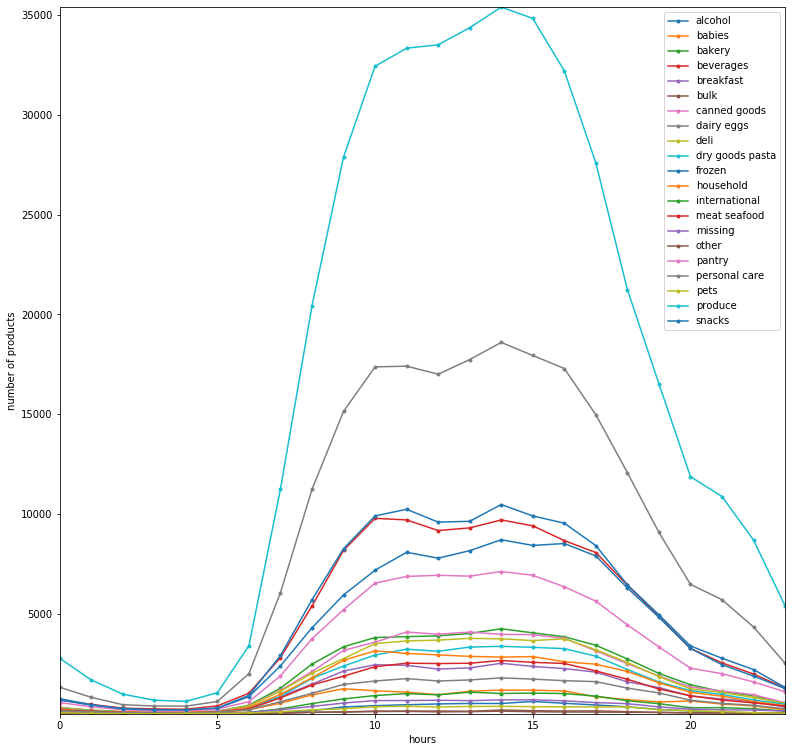

In [0]:
import matplotlib.pyplot as plt

groups = pd_df_products_dep_hour.groupby('department')

# Plot
fig, ax = plt.subplots()
ax.margins(0)
for name, group in groups:
    ax.plot(group.hour, group.num_products, marker='o', linestyle='-', ms=3, label=name)
ax.legend()
fig.set_size_inches(13,13)

plt.ylabel("number of products")
plt.xlabel("hours")
plt.show()

#### 3.1.3 Basket size

In [0]:
df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'
df_orders.createOrReplaceTempView("orders") # creates table 'orders'

# create a dataframe with the basket size for each order
df_basket_size = spark.sql('SELECT op.order_id as order, COUNT(op.product_id) as basket_size' 
               ' FROM order_prod op'
               ' INNER JOIN orders o ON op.order_id = o.order_id'
               ' GROUP BY order ORDER BY basket_size DESC')

df_basket_size.createOrReplaceTempView("order_basket_size") # creates table 'order_basket_size'

# create a dataframe with the number of orders for each basket size
df_num_orders_basket_size = spark.sql('SELECT obs.basket_size as basket_size, COUNT(obs.order) as number_orders' 
               ' FROM order_basket_size obs'
               ' GROUP BY basket_size ORDER BY basket_size')

In [0]:
pd_df_num_orders_basket_size = df_num_orders_basket_size.toPandas()

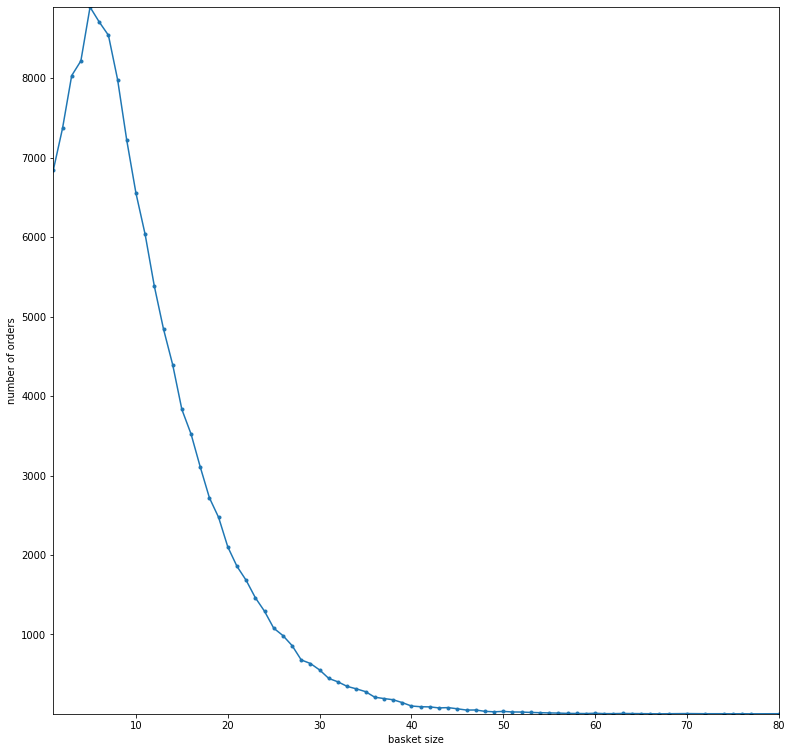

In [0]:
import matplotlib.pyplot as plt
# Plot
fig, ax = plt.subplots()
ax.margins(0)
ax.plot(pd_df_num_orders_basket_size.basket_size, pd_df_num_orders_basket_size.number_orders, marker='o', linestyle='-', ms=3)
fig.set_size_inches(13,13)

plt.ylabel("number of orders")
plt.xlabel("basket size")
plt.show()

### 3.2 Run MBA for the training set (15 points)

Using the orders from the ``order_products__train.csv``, create a data frame where each row contain just one column, the transaction, with the list of purchased products. For this task, you do not have to query for the product names to run the MBA algorithm. You can assume that the product name is its id. This can accelerate the algorithm since the product names can be quite big.

You must report the time spent to perform this task.

In [0]:
df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'

#create a dataframe with the transactions
df_transactions = spark.sql('SELECT COLLECT_LIST(op.product_id) AS transaction' 
               ' FROM order_prod op'
               ' GROUP BY op.order_id')

In [0]:
result_df.show(5)

+--------------------+
|         transaction|
+--------------------+
|[13176, 30827, 14...|
|[17203, 44008, 48...|
|             [29270]|
|             [45190]|
|[37524, 33731, 43...|
+--------------------+
only showing top 5 rows



In [0]:
# Map to patterns is redefined because the list of products in the transactions table is not in the same format
def map_to_patterns2(row):
    products = row.transaction
    products.sort()
    n_products = len(products)
    for i, p in enumerate(products):
        yield ((p,), 1)
        for j in range(i + 1, n_products):
            yield ((p, products[j]), 1)
            for k in range(j + 1, n_products):
                yield ((p, products[j], products[k]), 1)

In [0]:
df_order_prod_rdd = result_df.rdd

patterns_rdd = df_order_prod_rdd.flatMap(map_to_patterns2)

combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_product_by_key_sum)

subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns)

combined_rules = subpatterns_rdd.combineByKey(to_list, merge_value, merge_combiners)

assoc_rules = combined_rules.flatMap(map_to_assoc_rules)

In [0]:
%%time
assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).show(5, truncate=False)

+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
# Note we ran our notebook in Colab and some outputs were strangely displayed when we converted the Colab notebook to 
# the .ipynb file. Here a beautified output from the output cell above.
"""
+--------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|patterns            |association_rules                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
+--------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(30827,)            |[(30591, 0.010101010101010102), (19767, 0.010101010101010102), (12055, 0.001443001443001443), (33303, 0.004329004329004329), (7751, 0.004329004329004329), (1727, 0.001443001443001443), (31087, 0.001443001443001443), (34615, 0.002886002886002886), (16975, 0.001443001443001443), (49279, 0.002886002886002886), (9759, 0.001443001443001443), (9535, 0.001443001443001443), (33503, 0.001443001443001443), (29015, 0.001443001443001443), (33000, 0.01875901875901876), (16254, 0.002886002886002886), (1326, 0.001443001443001443), (7806, 0.001443001443001443), (39408, 0.012987012987012988), (42936, 0.001443001443001443), (28606, 0.001443001443001443), (48720, 0.001443001443001443), (43720, 0.004329004329004329), (14502, 0.001443001443001443), (25286, 0.001443001443001443), (23361, 0.001443001443001443), (47409, 0.001443001443001443), (5337, 0.002886002886002886), (25017, 0.002886002886002886), (33113, 0.001443001443001443), (42625, 0.002886002886002886), (34425, 0.002886002886002886), (34737, 0.001443001443001443), (43409, 0.001443001443001443), (13032, 0.008658008658008658), (15680, 0.002886002886002886), (37250, 0.004329004329004329), (16320, 0.001443001443001443), (34834, 0.002886002886002886), (43234, 0.001443001443001443), (40770, 0.002886002886002886), (35458, 0.001443001443001443), (42450, 0.001443001443001443), (44234, 0.001443001443001443), (23216, 0.001443001443001443), (17592, 0.001443001443001443), (2064, 0.001443001443001443), (9387, 0.017316017316017316), (11827, 0.002886002886002886), (38739, 0.007215007215007215), (7923, 0.001443001443001443), (18531, 0.001443001443001443), (25035, 0.001443001443001443), (14979, 0.002886002886002886), (13083, 0.002886002886002886), (32211, 0.002886002886002886), (48299, 0.004329004329004329), (47611, 0.001443001443001443), (42939, 0.001443001443001443), (819, 0.001443001443001443), (25146, 0.007215007215007215), (40348, 0.001443001443001443), (5994, 0.002886002886002886), (20618, 0.001443001443001443), (16594, 0.001443001443001443), (28626, 0.002886002886002886), (13802, 0.001443001443001443), (8802, 0.001443001443001443), (18362, 0.001443001443001443), (40660, 0.001443001443001443), (27845, 0.01443001443001443), (31573, 0.004329004329004329), (45453, 0.001443001443001443), (39461, 0.001443001443001443), (10077, 0.001443001443001443), (32573, 0.002886002886002886), (26405, 0.001443001443001443), (19173, 0.001443001443001443), (24925, 0.001443001443001443), (41565, 0.001443001443001443), (29429, 0.001443001443001443), (3868, 0.001443001443001443), (17052, 0.001443001443001443), (40174, 0.001443001443001443), (7644, 0.001443001443001443), (33614, 0.001443001443001443), (4100, 0.001443001443001443), (26436, 0.001443001443001443), (8260, 0.001443001443001443), (43975, 0.001443001443001443), (22999, 0.001443001443001443), (23103, 0.001443001443001443), (36463, 0.001443001443001443), (42455, 0.004329004329004329), (44239, 0.001443001443001443), (8767, 0.001443001443001443), (26759, 0.001443001443001443), (18135, 0.001443001443001443), (19831, 0.001443001443001443), (10335, 0.001443001443001443), (3798, 0.024531024531024532), (27966, 0.008658008658008658), (17862, 0.004329004329004329), (1806, 0.001443001443001443), (31960, 0.002886002886002886), (39696, 0.001443001443001443), (18102, 0.001443001443001443), (18358, 0.001443001443001443), (9358, 0.002886002886002886), (30960, 0.001443001443001443), (45264, 0.001443001443001443), (37176, 0.001443001443001443), (45064, 0.002886002886002886), (18534, 0.002886002886002886), (22782, 0.001443001443001443), (43584, 0.001443001443001443), (14161, 0.023088023088023088), (13129, 0.001443001443001443), (2113, 0.001443001443001443), (41065, 0.002886002886002886), (40897, 0.001443001443001443), (11193, 0.001443001443001443), (28473, 0.001443001443001443), (27841, 0.002886002886002886), (29553, 0.001443001443001443), (23313, 0.001443001443001443), (34601, 0.001443001443001443), (24265, 0.001443001443001443), (28785, 0.001443001443001443), (24441, 0.001443001443001443), (37065, 0.001443001443001443), (20448, 0.011544011544011544), (44410, 0.004329004329004329), (13304, 0.001443001443001443), (22400, 0.001443001443001443), (28688, 0.001443001443001443), (35898, 0.001443001443001443), (17720, 0.001443001443001443), (44098, 0.001443001443001443), (45938, 0.001443001443001443), (34898, 0.001443001443001443), (5720, 0.001443001443001443), (3752, 0.001443001443001443), (36522, 0.001443001443001443), (28112, 0.001443001443001443), (39275, 0.10678210678210678), (4731, 0.002886002886002886), (37067, 0.002886002886002886), (31387, 0.002886002886002886), (5115, 0.002886002886002886), (2651, 0.001443001443001443), (44475, 0.002886002886002886), (47475, 0.001443001443001443), (10011, 0.001443001443001443), (42803, 0.002886002886002886), (31963, 0.001443001443001443), (43724, 0.001443001443001443), (46516, 0.005772005772005772), (5450, 0.004329004329004329), (2770, 0.001443001443001443), (5322, 0.001443001443001443), (1202, 0.001443001443001443), (48036, 0.001443001443001443), (11706, 0.001443001443001443), (10957, 0.001443001443001443), (17245, 0.001443001443001443), (25653, 0.004329004329004329), (27477, 0.004329004329004329), (42629, 0.010101010101010102), (37317, 0.007215007215007215), (45037, 0.001443001443001443), (10173, 0.002886002886002886), (34005, 0.004329004329004329), (45205, 0.002886002886002886), (13909, 0.001443001443001443), (7925, 0.001443001443001443), (20893, 0.001443001443001443), (46941, 0.001443001443001443), (21780, 0.001443001443001443), (19828, 0.01875901875901876), (3308, 0.002886002886002886), (13708, 0.001443001443001443), (5404, 0.001443001443001443), (10060, 0.001443001443001443), (8884, 0.001443001443001443), (9292, 0.001443001443001443), (13319, 0.001443001443001443), (39527, 0.001443001443001443), (41319, 0.001443001443001443), (15999, 0.001443001443001443), (11215, 0.001443001443001443), (22367, 0.001443001443001443), (18583, 0.004329004329004329), (27839, 0.001443001443001443), (41743, 0.001443001443001443), (24166, 0.001443001443001443), (29518, 0.001443001443001443), (22766, 0.002886002886002886), (38664, 0.002886002886002886), (27790, 0.007215007215007215), (39024, 0.001443001443001443), (30278, 0.001443001443001443), (22622, 0.001443001443001443), (30422, 0.001443001443001443), (14742, 0.001443001443001443), (7158, 0.001443001443001443), (34824, 0.001443001443001443), (262, 0.001443001443001443), (4006, 0.001443001443001443), (46129, 0.007215007215007215), (38241, 0.001443001443001443), (7249, 0.005772005772005772), (37553, 0.001443001443001443), (23753, 0.001443001443001443), (14977, 0.001443001443001443), (32137, 0.001443001443001443), (21201, 0.001443001443001443), (31825, 0.001443001443001443), (46266, 0.007215007215007215), (27360, 0.005772005772005772), (45066, 0.001443001443001443), (29088, 0.001443001443001443), (30664, 0.001443001443001443), (7952, 0.001443001443001443), (4936, 0.001443001443001443), (5160, 0.001443001443001443), (14419, 0.007215007215007215), (30027, 0.001443001443001443), (403, 0.001443001443001443), (33043, 0.002886002886002886), (23915, 0.001443001443001443), (42443, 0.001443001443001443), (34355, 0.001443001443001443), (36139, 0.001443001443001443), (8843, 0.001443001443001443), (5067, 0.004329004329004329), (17811, 0.001443001443001443), (22091, 0.001443001443001443), (15171, 0.001443001443001443), (39339, 0.001443001443001443), (47788, 0.02886002886002886), (22802, 0.010101010101010102), (48364, 0.001443001443001443), (30162, 0.005772005772005772), (39900, 0.001443001443001443), (31964, 0.004329004329004329), (27954, 0.001443001443001443), (41804, 0.001443001443001443), (14962, 0.001443001443001443), (3594, 0.001443001443001443), (32700, 0.001443001443001443), (20698, 0.001443001443001443), (23029, 0.001443001443001443), (2469, 0.001443001443001443), (31501, 0.001443001443001443), (33493, 0.004329004329004329), (25861, 0.001443001443001443), (38381, 0.001443001443001443), (33181, 0.001443001443001443), (21333, 0.002886002886002886), (15829, 0.001443001443001443), (8149, 0.001443001443001443), (10333, 0.001443001443001443), (37493, 0.001443001443001443), (19508, 0.005772005772005772), (8372, 0.001443001443001443), (29028, 0.001443001443001443), (5388, 0.007215007215007215), (24508, 0.001443001443001443), (26692, 0.001443001443001443), (11740, 0.002886002886002886), (48614, 0.001443001443001443), (38006, 0.001443001443001443), (19156, 0.001443001443001443), (10492, 0.001443001443001443), (43414, 0.001443001443001443), (48726, 0.001443001443001443), (14148, 0.001443001443001443), (48903, 0.001443001443001443), (15455, 0.001443001443001443), (32079, 0.01443001443001443), (43279, 0.004329004329004329), (44479, 0.002886002886002886), (23423, 0.007215007215007215), (11943, 0.001443001443001443), (41383, 0.001443001443001443), (5351, 0.002886002886002886), (38383, 0.001443001443001443), (36591, 0.001443001443001443), (4447, 0.001443001443001443), (3990, 0.004329004329004329), (30406, 0.012987012987012988), (43712, 0.001443001443001443), (30678, 0.001443001443001443), (35824, 0.004329004329004329), (17046, 0.001443001443001443), (21070, 0.001443001443001443), (28993, 0.005772005772005772), (47601, 0.001443001443001443), (2449, 0.002886002886002886), (11777, 0.004329004329004329), (25985, 0.001443001443001443), (9689, 0.001443001443001443), (18977, 0.001443001443001443), (30361, 0.001443001443001443), (1, 0.001443001443001443), (49505, 0.001443001443001443), (40338, 0.004329004329004329), (23288, 0.005772005772005772), (35762, 0.001443001443001443), (19760, 0.001443001443001443), (26800, 0.001443001443001443), (14144, 0.001443001443001443), (45866, 0.001443001443001443), (15840, 0.001443001443001443), (36338, 0.001443001443001443), (30024, 0.001443001443001443), (27323, 0.005772005772005772), (22475, 0.001443001443001443), (40403, 0.001443001443001443), (46931, 0.005772005772005772), (16539, 0.005772005772005772), (20947, 0.001443001443001443), (12099, 0.001443001443001443), (2091, 0.001443001443001443), (33731, 0.001443001443001443), (22667, 0.001443001443001443), (5258, 0.025974025974025976), (25762, 0.001443001443001443), (47652, 0.001443001443001443), (4562, 0.001443001443001443), (21986, 0.001443001443001443), (25890, 0.004329004329004329), (39028, 0.001443001443001443), (31564, 0.002886002886002886), (14018, 0.001443001443001443), (17386, 0.001443001443001443), (23165, 0.002886002886002886), (10685, 0.001443001443001443), (17053, 0.001443001443001443), (3229, 0.001443001443001443), (33357, 0.001443001443001443), (46133, 0.001443001443001443), (31141, 0.001443001443001443), (40453, 0.001443001443001443), (9597, 0.001443001443001443), (20285, 0.001443001443001443), (49270, 0.001443001443001443), (5716, 0.001443001443001443), (28204, 0.005772005772005772), (22524, 0.001443001443001443), (33606, 0.001443001443001443), (22124, 0.001443001443001443), (33494, 0.001443001443001443), (3020, 0.001443001443001443), (11924, 0.001443001443001443), (32390, 0.001443001443001443), (13780, 0.001443001443001443), (31702, 0.001443001443001443), (22788, 0.002886002886002886), (37070, 0.001443001443001443), (32455, 0.01443001443001443), (45447, 0.001443001443001443), (35767, 0.001443001443001443), (38871, 0.001443001443001443), (21951, 0.001443001443001443), (42447, 0.002886002886002886), (43967, 0.001443001443001443), (37247, 0.001443001443001443), (18471, 0.001443001443001443), (31831, 0.001443001443001443), (28911, 0.001443001443001443), (6022, 0.001443001443001443), (38368, 0.001443001443001443), (41480, 0.001443001443001443), (30214, 0.001443001443001443), (35264, 0.001443001443001443), (33480, 0.001443001443001443), (21137, 0.09523809523809523), (32689, 0.08658008658008658), (39953, 0.001443001443001443), (21513, 0.001443001443001443), (33857, 0.001443001443001443), (21313, 0.001443001443001443), (10441, 0.007215007215007215), (45681, 0.001443001443001443), (17409, 0.001443001443001443), (11265, 0.001443001443001443), (43889, 0.001443001443001443), (22281, 0.001443001443001443), (39889, 0.001443001443001443), (47402, 0.01875901875901876), (15200, 0.015873015873015872), (45194, 0.002886002886002886), (4920, 0.04184704184704185), (33106, 0.001443001443001443), (14256, 0.001443001443001443), (5251, 0.001443001443001443), (45683, 0.001443001443001443), (6195, 0.001443001443001443), (32691, 0.002886002886002886), (6003, 0.001443001443001443), (37059, 0.002886002886002886), (30611, 0.001443001443001443), (30339, 0.002886002886002886), (27531, 0.001443001443001443), (39891, 0.001443001443001443), (23594, 0.001443001443001443), (21938, 0.011544011544011544), (36204, 0.001443001443001443), (26914, 0.007215007215007215), (22610, 0.005772005772005772), (47404, 0.001443001443001443), (35628, 0.002886002886002886), (40516, 0.007215007215007215), (10602, 0.008658008658008658), (46820, 0.001443001443001443), (27770, 0.001443001443001443), (19106, 0.001443001443001443), (3562, 0.002886002886002886), (44092, 0.001443001443001443), (31317, 0.001443001443001443), (15269, 0.002886002886002886), (4269, 0.001443001443001443), (14197, 0.001443001443001443), (19981, 0.001443001443001443), (24933, 0.001443001443001443), (17652, 0.004329004329004329), (47854, 0.001443001443001443), (22476, 0.001443001443001443), (26900, 0.005772005772005772), (34358, 0.002886002886002886), (30830, 0.001443001443001443), (44542, 0.001443001443001443), (14084, 0.001443001443001443), (41558, 0.001443001443001443), (24135, 0.01875901875901876), (40519, 0.002886002886002886), (29487, 0.020202020202020204), (3847, 0.001443001443001443), (23375, 0.005772005772005772), (6631, 0.002886002886002886), (8671, 0.001443001443001443), (3223, 0.001443001443001443), (49511, 0.002886002886002886), (33232, 0.001443001443001443), (14862, 0.001443001443001443), (23734, 0.004329004329004329), (38856, 0.001443001443001443), (30486, 0.002886002886002886), (18078, 0.001443001443001443), (35440, 0.001443001443001443), (5097, 0.002886002886002886), (24673, 0.001443001443001443), (31553, 0.005772005772005772), (30057, 0.002886002886002886), (1689, 0.004329004329004329), (25281, 0.001443001443001443), (30745, 0.001443001443001443), (6193, 0.001443001443001443), (16993, 0.001443001443001443), (43154, 0.01875901875901876), (31066, 0.001443001443001443), (34594, 0.001443001443001443), (22600, 0.001443001443001443), (26312, 0.001443001443001443), (36690, 0.001443001443001443), (39954, 0.002886002886002886), (17008, 0.004329004329004329), (35266, 0.001443001443001443), (25312, 0.001443001443001443), (35378, 0.001443001443001443), (7600, 0.001443001443001443), (31954, 0.001443001443001443), (14528, 0.001443001443001443), (16283, 0.05483405483405483), (27243, 0.001443001443001443), (32923, 0.008658008658008658), (25043, 0.001443001443001443), (39019, 0.001443001443001443), (7227, 0.001443001443001443), (44331, 0.001443001443001443), (46059, 0.001443001443001443), (43643, 0.001443001443001443), (36923, 0.001443001443001443), (46323, 0.001443001443001443), (994, 0.001443001443001443), (25938, 0.004329004329004329), (44580, 0.004329004329004329), (226, 0.001443001443001443), (45260, 0.007215007215007215), (29930, 0.001443001443001443), (19842, 0.001443001443001443), (20869, 0.001443001443001443), (39893, 0.001443001443001443), (37173, 0.001443001443001443), (1117, 0.004329004329004329), (13077, 0.001443001443001443), (325, 0.002886002886002886), (6789, 0.001443001443001443), (47357, 0.002886002886002886), (39581, 0.001443001443001443), (10749, 0.001443001443001443), (35269, 0.001443001443001443), (25588, 0.012987012987012988), (26348, 0.004329004329004329), (26620, 0.002886002886002886), (32006, 0.001443001443001443), (13092, 0.001443001443001443), (44830, 0.001443001443001443), (12732, 0.005772005772005772), (500, 0.005772005772005772), (4428, 0.001443001443001443), (49030, 0.001443001443001443), (19348, 0.004329004329004329), (9084, 0.004329004329004329), (4780, 0.001443001443001443), (19076, 0.001443001443001443), (9068, 0.001443001443001443), (29388, 0.001443001443001443), (35894, 0.002886002886002886), (27676, 0.001443001443001443), (4924, 0.001443001443001443), (49198, 0.001443001443001443), (6852, 0.001443001443001443), (42063, 0.001443001443001443), (24535, 0.001443001443001443), (35383, 0.001443001443001443), (31759, 0.01443001443001443), (36695, 0.001443001443001443), (17334, 0.001443001443001443), (45496, 0.001443001443001443), (24622, 0.001443001443001443), (33720, 0.001443001443001443), (8590, 0.005772005772005772), (27086, 0.001443001443001443), (19134, 0.001443001443001443), (9366, 0.001443001443001443), (45608, 0.001443001443001443), (16710, 0.001443001443001443), (41984, 0.001443001443001443), (7390, 0.001443001443001443), (37984, 0.001443001443001443), (15577, 0.001443001443001443), (13881, 0.001443001443001443), (29657, 0.001443001443001443), (27801, 0.001443001443001443), (2489, 0.001443001443001443), (26505, 0.001443001443001443), (17569, 0.001443001443001443), (2841, 0.002886002886002886), (45185, 0.001443001443001443), (41921, 0.001443001443001443), (27336, 0.001443001443001443), (13216, 0.002886002886002886), (2376, 0.001443001443001443), (14640, 0.001443001443001443), (34234, 0.001443001443001443), (46058, 0.005772005772005772), (11488, 0.001443001443001443), (38546, 0.001443001443001443), (8619, 0.001443001443001443), (28907, 0.001443001443001443), (37611, 0.001443001443001443), (939, 0.001443001443001443), (35507, 0.001443001443001443), (28211, 0.002886002886002886), (23955, 0.001443001443001443), (48395, 0.001443001443001443), (16419, 0.001443001443001443), (3107, 0.001443001443001443), (5315, 0.001443001443001443), (42299, 0.001443001443001443), (15610, 0.001443001443001443), (322, 0.001443001443001443), (13042, 0.004329004329004329), (48532, 0.002886002886002886), (23178, 0.001443001443001443), (35132, 0.001443001443001443), (47532, 0.001443001443001443), (39332, 0.001443001443001443), (27706, 0.001443001443001443), (40332, 0.002886002886002886), (27690, 0.001443001443001443), (46060, 0.001443001443001443), (46061, 0.007215007215007215), (41125, 0.001443001443001443), (6901, 0.002886002886002886), (16933, 0.001443001443001443), (35445, 0.002886002886002886), (16237, 0.001443001443001443), (3021, 0.001443001443001443), (3125, 0.001443001443001443), (9644, 0.002886002886002886), (31958, 0.001443001443001443), (12212, 0.001443001443001443), (588, 0.001443001443001443), (17108, 0.001443001443001443), (34551, 0.005772005772005772), (23719, 0.007215007215007215), (5015, 0.001443001443001443), (13535, 0.010101010101010102), (31559, 0.001443001443001443), (49327, 0.001443001443001443), (25647, 0.001443001443001443), (36023, 0.001443001443001443), (28647, 0.001443001443001443), (8479, 0.001443001443001443), (12679, 0.001443001443001443), (34160, 0.001443001443001443), (47144, 0.002886002886002886), (38160, 0.001443001443001443), (43568, 0.001443001443001443), (48144, 0.001443001443001443), (24830, 0.002886002886002886), (20670, 0.002886002886002886), (9494, 0.001443001443001443), (1670, 0.001443001443001443), (49248, 0.001443001443001443), (40144, 0.001443001443001443), (42360, 0.001443001443001443), (10550, 0.001443001443001443), (22470, 0.001443001443001443), (8153, 0.004329004329004329), (12513, 0.001443001443001443), (42049, 0.001443001443001443), (1529, 0.001443001443001443), (8056, 0.002886002886002886), (432, 0.002886002886002886), (11440, 0.001443001443001443), (48018, 0.001443001443001443), (33098, 0.001443001443001443), (3776, 0.001443001443001443), (20608, 0.001443001443001443), (39394, 0.001443001443001443), (8803, 0.04040404040404041), (10227, 0.002886002886002886), (21195, 0.030303030303030304), (46363, 0.010101010101010102), (31747, 0.001443001443001443), (17419, 0.004329004329004329), (1891, 0.001443001443001443), (10371, 0.002886002886002886), (49083, 0.008658008658008658), (39947, 0.001443001443001443), (19019, 0.001443001443001443), (11451, 0.001443001443001443), (41787, 0.002886002886002886), (23763, 0.001443001443001443), (34947, 0.001443001443001443), (11323, 0.001443001443001443), (29731, 0.001443001443001443), (32851, 0.001443001443001443), (38300, 0.007215007215007215), (30170, 0.001443001443001443), (48708, 0.001443001443001443), (21962, 0.001443001443001443), (22362, 0.007215007215007215), (14466, 0.001443001443001443), (46812, 0.001443001443001443), (14861, 0.001443001443001443), (23909, 0.008658008658008658), (9493, 0.001443001443001443), (5157, 0.002886002886002886), (15869, 0.001443001443001443), (17157, 0.005772005772005772), (4605, 0.008658008658008658), (19677, 0.001443001443001443), (22957, 0.001443001443001443), (10917, 0.001443001443001443), (37613, 0.001443001443001443), (7805, 0.001443001443001443), (8637, 0.001443001443001443), (32989, 0.001443001443001443), (4724, 0.07647907647907648), (9020, 0.007215007215007215), (21516, 0.001443001443001443), (26172, 0.004329004329004329), (1468, 0.001443001443001443), (13948, 0.001443001443001443), (23484, 0.007215007215007215), (31134, 0.001443001443001443), (19068, 0.001443001443001443), (32446, 0.002886002886002886), (41238, 0.001443001443001443), (17316, 0.001443001443001443), (27500, 0.001443001443001443), (43958, 0.001443001443001443), (14159, 0.023088023088023088), (40199, 0.01875901875901876), (35887, 0.002886002886002886), (49191, 0.001443001443001443), (30183, 0.001443001443001443), (34887, 0.001443001443001443), (6046, 0.004329004329004329), (44632, 0.007215007215007215), (17902, 0.010101010101010102), (42736, 0.004329004329004329), (2966, 0.001443001443001443), (24142, 0.001443001443001443), (20118, 0.001443001443001443), (35320, 0.001443001443001443), (35121, 0.001443001443001443), (40009, 0.002886002886002886), (4913, 0.002886002886002886), (47209, 0.007215007215007215), (25817, 0.001443001443001443), (36321, 0.001443001443001443), (4377, 0.001443001443001443), (48833, 0.001443001443001443), (12817, 0.001443001443001443), (32433, 0.002886002886002886), (28985, 0.001443001443001443), (43209, 0.001443001443001443), (10193, 0.002886002886002886), (6481, 0.002886002886002886), (46049, 0.001443001443001443), (23001, 0.001443001443001443), (31433, 0.001443001443001443), (44570, 0.008658008658008658), (49082, 0.002886002886002886), (29224, 0.001443001443001443), (17168, 0.004329004329004329), (26104, 0.004329004329004329), (7736, 0.001443001443001443), (46562, 0.002886002886002886), (17344, 0.001443001443001443), (5819, 0.001443001443001443), (15923, 0.001443001443001443), (32747, 0.004329004329004329), (1875, 0.001443001443001443), (29987, 0.001443001443001443), (12011, 0.001443001443001443), (9411, 0.001443001443001443), (33651, 0.001443001443001443), (29363, 0.002886002886002886), (37052, 0.001443001443001443), (43772, 0.011544011544011544), (890, 0.01443001443001443), (47348, 0.005772005772005772), (43460, 0.001443001443001443), (46676, 0.002886002886002886), (2458, 0.001443001443001443), (35948, 0.001443001443001443), (6258, 0.001443001443001443), (20378, 0.002886002886002886), (30274, 0.001443001443001443), (12341, 0.17027417027417027), (30949, 0.001443001443001443), (3957, 0.002886002886002886), (10181, 0.001443001443001443), (24517, 0.001443001443001443), (24389, 0.001443001443001443), (8013, 0.002886002886002886), (9573, 0.001443001443001443), (25869, 0.001443001443001443), (30517, 0.001443001443001443), (34789, 0.001443001443001443), (40261, 0.001443001443001443), (45253, 0.001443001443001443), (2581, 0.001443001443001443), (34165, 0.002886002886002886), (46677, 0.001443001443001443), (10053, 0.001443001443001443), (20381, 0.001443001443001443), (24852, 0.02886002886002886), (15772, 0.011544011544011544), (35886, 0.011544011544011544), (15004, 0.004329004329004329), (2596, 0.001443001443001443), (12980, 0.004329004329004329), (44398, 0.001443001443001443), (16900, 0.001443001443001443), (8380, 0.001443001443001443), (9839, 0.023088023088023088), (47775, 0.001443001443001443), (35951, 0.02886002886002886), (6383, 0.004329004329004329), (2855, 0.007215007215007215), (42791, 0.002886002886002886), (4807, 0.001443001443001443), (14111, 0.001443001443001443), (17679, 0.001443001443001443), (35263, 0.007215007215007215), (7631, 0.002886002886002886), (33791, 0.001443001443001443), (22359, 0.001443001443001443), (17807, 0.001443001443001443), (26927, 0.001443001443001443), (18479, 0.001443001443001443), (31872, 0.001443001443001443), (27910, 0.001443001443001443), (35184, 0.005772005772005772), (45488, 0.004329004329004329), (12542, 0.002886002886002886), (6174, 0.001443001443001443), (44384, 0.001443001443001443), (6478, 0.001443001443001443), (38288, 0.001443001443001443), (44008, 0.001443001443001443), (21385, 0.025974025974025976), (48697, 0.004329004329004329), (4641, 0.001443001443001443), (42913, 0.001443001443001443), (11009, 0.002886002886002886), (28289, 0.001443001443001443), (1873, 0.001443001443001443), (10049, 0.001443001443001443), (8536, 0.005772005772005772), (3216, 0.002886002886002886), (11520, 0.002886002886002886), (14104, 0.001443001443001443), (15672, 0.001443001443001443), (1000, 0.001443001443001443), (47946, 0.001443001443001443), (40746, 0.001443001443001443), (42426, 0.001443001443001443), (26088, 0.002886002886002886), (1368, 0.001443001443001443), (11152, 0.001443001443001443), (36322, 0.002886002886002886), (36010, 0.001443001443001443), (11384, 0.001443001443001443), (39322, 0.001443001443001443), (9176, 0.001443001443001443), (22080, 0.001443001443001443), (25464, 0.001443001443001443), (10611, 0.001443001443001443), (38291, 0.001443001443001443), (20955, 0.02886002886002886), (46803, 0.002886002886002886), (31187, 0.001443001443001443), (7131, 0.007215007215007215), (20323, 0.001443001443001443), (32299, 0.001443001443001443), (35124, 0.001443001443001443), (48524, 0.004329004329004329), (32748, 0.001443001443001443), (11266, 0.004329004329004329), (7690, 0.001443001443001443), (17794, 0.008658008658008658), (1194, 0.002886002886002886), (33228, 0.001443001443001443), (25802, 0.001443001443001443), (43637, 0.001443001443001443), (22021, 0.002886002886002886), (34229, 0.001443001443001443), (37229, 0.001443001443001443), (397, 0.001443001443001443), (38117, 0.001443001443001443), (41853, 0.001443001443001443), (15053, 0.001443001443001443), (19389, 0.004329004329004329), (4660, 0.001443001443001443), (5428, 0.001443001443001443), (10900, 0.001443001443001443), (24964, 0.002886002886002886), (29268, 0.001443001443001443), (30950, 0.001443001443001443), (23156, 0.001443001443001443), (23615, 0.001443001443001443), (37919, 0.011544011544011544), (2359, 0.001443001443001443), (34343, 0.002886002886002886), (33231, 0.001443001443001443), (24799, 0.001443001443001443), (48527, 0.001443001443001443), (6335, 0.001443001443001443), (16215, 0.001443001443001443), (43136, 0.008658008658008658), (25670, 0.001443001443001443), (20518, 0.005772005772005772), (8518, 0.005772005772005772), (10814, 0.001443001443001443), (44560, 0.001443001443001443), (86, 0.001443001443001443), (33464, 0.002886002886002886), (40136, 0.001443001443001443), (3265, 0.025974025974025976), (35561, 0.047619047619047616), (41665, 0.001443001443001443), (44449, 0.007215007215007215), (13385, 0.001443001443001443), (21497, 0.002886002886002886), (48761, 0.002886002886002886), (46665, 0.001443001443001443), (47337, 0.001443001443001443), (25513, 0.001443001443001443), (169, 0.001443001443001443), (39561, 0.001443001443001443), (25753, 0.001443001443001443), (28625, 0.001443001443001443), (42665, 0.001443001443001443), (48449, 0.001443001443001443), (17976, 0.007215007215007215), (25288, 0.001443001443001443), (46802, 0.007215007215007215), (18376, 0.001443001443001443), (25544, 0.004329004329004329), (13544, 0.001443001443001443), (38714, 0.001443001443001443), (14312, 0.001443001443001443), (41290, 0.001443001443001443), (31610, 0.001443001443001443), (47586, 0.001443001443001443), (36074, 0.001443001443001443), (12232, 0.001443001443001443), (45979, 0.001443001443001443), (46979, 0.008658008658008658), (18811, 0.004329004329004329), (24235, 0.001443001443001443), (46667, 0.002886002886002886), (43875, 0.001443001443001443), (13819, 0.001443001443001443), (41355, 0.001443001443001443), (49243, 0.001443001443001443), (17122, 0.03751803751803752), (3298, 0.017316017316017316), (37404, 0.001443001443001443), (40388, 0.001443001443001443), (18818, 0.002886002886002886), (46804, 0.004329004329004329), (39388, 0.001443001443001443), (22178, 0.004329004329004329), (13914, 0.007215007215007215), (8490, 0.001443001443001443), (47388, 0.001443001443001443), (39812, 0.001443001443001443), (19322, 0.001443001443001443), (15770, 0.001443001443001443), (20082, 0.001443001443001443), (22034, 0.001443001443001443), (26861, 0.001443001443001443), (1957, 0.008658008658008658), (35501, 0.001443001443001443), (23205, 0.001443001443001443), (30877, 0.001443001443001443), (18573, 0.001443001443001443), (49381, 0.001443001443001443), (3397, 0.001443001443001443), (20940, 0.04184704184704185), (26764, 0.001443001443001443), (45854, 0.001443001443001443), (5380, 0.001443001443001443), (156, 0.001443001443001443), (26940, 0.001443001443001443), (29223, 0.04184704184704185), (34407, 0.004329004329004329), (32303, 0.03751803751803752), (26183, 0.001443001443001443), (18023, 0.005772005772005772), (43703, 0.001443001443001443), (49383, 0.002886002886002886), (9175, 0.001443001443001443), (21543, 0.001443001443001443), (32615, 0.001443001443001443), (18151, 0.001443001443001443), (23646, 0.004329004329004329), (45840, 0.002886002886002886), (47040, 0.001443001443001443), (37104, 0.001443001443001443), (10078, 0.001443001443001443), (2046, 0.001443001443001443), (5750, 0.001443001443001443), (46041, 0.007215007215007215), (16953, 0.012987012987012988), (4353, 0.001443001443001443), (39001, 0.005772005772005772), (2273, 0.001443001443001443), (20305, 0.002886002886002886), (13176, 0.1774891774891775), (48762, 0.010101010101010102), (5240, 0.001443001443001443), (34466, 0.01875901875901876), (26040, 0.002886002886002886), (39250, 0.001443001443001443), (14168, 0.004329004329004329), (14488, 0.002886002886002886), (34778, 0.001443001443001443), (18232, 0.001443001443001443), (28016, 0.001443001443001443), (38154, 0.001443001443001443), (37354, 0.001443001443001443), (14947, 0.001443001443001443), (37107, 0.001443001443001443), (12427, 0.004329004329004329), (40939, 0.011544011544011544), (34643, 0.001443001443001443), (47043, 0.001443001443001443), (9755, 0.002886002886002886), (46107, 0.001443001443001443), (4043, 0.001443001443001443), (4210, 0.005772005772005772), (22922, 0.001443001443001443), (23826, 0.001443001443001443), (42356, 0.002886002886002886), (5962, 0.004329004329004329), (30338, 0.001443001443001443), (21405, 0.004329004329004329), (24253, 0.001443001443001443), (38157, 0.001443001443001443), (43565, 0.004329004329004329), (39877, 0.001443001443001443), (21292, 0.14574314574314573), (20796, 0.002886002886002886), (17148, 0.001443001443001443), (3060, 0.001443001443001443), (39190, 0.001443001443001443), (46806, 0.001443001443001443), (39814, 0.001443001443001443), (26324, 0.001443001443001443), (16020, 0.001443001443001443), (28020, 0.001443001443001443), (33783, 0.021645021645021644), (2119, 0.001443001443001443), (17071, 0.001443001443001443), (3391, 0.001443001443001443), (48455, 0.001443001443001443), (16575, 0.001443001443001443), (2295, 0.001443001443001443), (16703, 0.001443001443001443), (28103, 0.001443001443001443), (49247, 0.001443001443001443), (25878, 0.001443001443001443), (12606, 0.007215007215007215), (13654, 0.002886002886002886), (40688, 0.002886002886002886), (28174, 0.001443001443001443), (47376, 0.001443001443001443), (19766, 0.001443001443001443), (9582, 0.001443001443001443), (33081, 0.01443001443001443), (27033, 0.004329004329004329), (15937, 0.002886002886002886), (13097, 0.015873015873015872), (27665, 0.001443001443001443), (41593, 0.001443001443001443), (6873, 0.001443001443001443), (40969, 0.004329004329004329), (19097, 0.001443001443001443), (45481, 0.001443001443001443), (32177, 0.001443001443001443), (6729, 0.002886002886002886), (2481, 0.001443001443001443), (23537, 0.001443001443001443), (5161, 0.001443001443001443), (2225, 0.001443001443001443), (3689, 0.001443001443001443), (21872, 0.001443001443001443), (47626, 0.021645021645021644), (21616, 0.005772005772005772), (264, 0.001443001443001443), (40002, 0.002886002886002886), (3040, 0.001443001443001443), (32538, 0.007215007215007215), (26128, 0.001443001443001443), (19368, 0.001443001443001443), (47042, 0.004329004329004329), (44514, 0.002886002886002886), (25368, 0.001443001443001443), (13624, 0.001443001443001443), (15392, 0.001443001443001443), (15872, 0.002886002886002886), (24184, 0.002886002886002886), (49306, 0.001443001443001443), (11416, 0.001443001443001443), (18067, 0.004329004329004329), (32971, 0.007215007215007215), (13259, 0.015873015873015872), (7147, 0.008658008658008658), (42483, 0.001443001443001443), (9203, 0.001443001443001443), (15203, 0.001443001443001443), (17691, 0.001443001443001443), (21955, 0.001443001443001443), (9963, 0.001443001443001443), (26483, 0.001443001443001443), (3243, 0.001443001443001443), (33395, 0.001443001443001443), (30731, 0.001443001443001443), (24555, 0.001443001443001443), (33083, 0.001443001443001443), (37283, 0.001443001443001443), (5451, 0.001443001443001443), (4683, 0.001443001443001443), (5818, 0.007215007215007215), (36316, 0.001443001443001443), (15602, 0.001443001443001443), (5194, 0.002886002886002886), (37220, 0.001443001443001443), (41220, 0.001443001443001443), (5586, 0.001443001443001443), (27714, 0.001443001443001443), (31805, 0.07792207792207792), (32541, 0.001443001443001443), (21573, 0.027417027417027416), (16213, 0.001443001443001443), (6109, 0.001443001443001443), (48205, 0.011544011544011544), (46309, 0.001443001443001443), (43205, 0.002886002886002886), (9741, 0.002886002886002886), (22469, 0.001443001443001443), (49141, 0.001443001443001443), (32429, 0.002886002886002886), (6765, 0.001443001443001443), (31541, 0.001443001443001443), (37158, 0.004329004329004329), (1940, 0.010101010101010102), (44142, 0.010101010101010102), (33782, 0.001443001443001443), (47766, 0.017316017316017316), (11004, 0.001443001443001443), (34582, 0.004329004329004329), (48454, 0.001443001443001443), (48142, 0.001443001443001443), (22948, 0.001443001443001443), (30287, 0.001443001443001443), (3999, 0.001443001443001443), (8615, 0.001443001443001443), (9231, 0.001443001443001443), (7175, 0.001443001443001443), (9487, 0.001443001443001443), (44943, 0.001443001443001443), (44319, 0.001443001443001443), (2519, 0.001443001443001443), (47831, 0.001443001443001443), (30191, 0.001443001443001443), (43319, 0.001443001443001443), (38768, 0.06637806637806638), (6758, 0.01443001443001443), (38928, 0.017316017316017316), (33768, 0.05339105339105339), (42768, 0.011544011544011544), (14582, 0.001443001443001443), (38456, 0.001443001443001443), (34568, 0.001443001443001443), (14001, 0.005772005772005772), (8193, 0.004329004329004329), (38929, 0.001443001443001443), (32833, 0.002886002886002886), (33833, 0.001443001443001443), (43129, 0.001443001443001443), (15201, 0.001443001443001443), (26497, 0.002886002886002886), (46969, 0.001443001443001443), (24361, 0.001443001443001443), (24489, 0.001443001443001443), (42345, 0.001443001443001443), (42282, 0.024531024531024532), (8048, 0.14285714285714285), (30720, 0.024531024531024532), (16920, 0.001443001443001443), (34282, 0.002886002886002886), (48890, 0.001443001443001443), (35866, 0.002886002886002886), (26384, 0.001443001443001443), (40490, 0.001443001443001443), (29536, 0.001443001443001443), (46906, 0.001443001443001443), (49235, 0.01443001443001443), (42347, 0.001443001443001443), (33147, 0.027417027417027416), (41971, 0.001443001443001443), (9339, 0.001443001443001443), (25187, 0.001443001443001443), (43867, 0.004329004329004329), (39555, 0.002886002886002886), (29091, 0.001443001443001443), (20114, 0.007215007215007215), (43692, 0.011544011544011544), (45004, 0.001443001443001443), (1538, 0.001443001443001443), (48004, 0.001443001443001443), (40492, 0.001443001443001443), (41596, 0.001443001443001443), (36180, 0.001443001443001443), (32772, 0.001443001443001443), (2962, 0.001443001443001443), (1522, 0.001443001443001443), (14005, 0.001443001443001443), (13877, 0.001443001443001443), (33709, 0.001443001443001443), (7021, 0.001443001443001443), (43693, 0.001443001443001443), (44381, 0.001443001443001443), (32293, 0.001443001443001443), (428, 0.001443001443001443), (30588, 0.008658008658008658), (19972, 0.004329004329004329), (36430, 0.001443001443001443), (35430, 0.001443001443001443), (11580, 0.001443001443001443), (40742, 0.002886002886002886), (47830, 0.001443001443001443), (18359, 0.002886002886002886), (2015, 0.001443001443001443), (14439, 0.001443001443001443), (46799, 0.001443001443001443), (27663, 0.001443001443001443), (4639, 0.005772005772005772), (45007, 0.007215007215007215), (1631, 0.001443001443001443), (12087, 0.001443001443001443), (311, 0.001443001443001443), (33087, 0.001443001443001443), (49007, 0.001443001443001443), (24262, 0.001443001443001443), (45832, 0.001443001443001443), (43504, 0.001443001443001443), (43928, 0.001443001443001443), (15790, 0.001443001443001443), (48192, 0.001443001443001443), (47504, 0.002886002886002886), (39928, 0.001443001443001443), (7606, 0.002886002886002886), (5782, 0.001443001443001443), (34208, 0.001443001443001443), (37096, 0.001443001443001443), (49608, 0.001443001443001443), (34320, 0.001443001443001443), (48193, 0.005772005772005772), (39993, 0.005772005772005772), (2433, 0.010101010101010102), (30777, 0.007215007215007215), (6585, 0.001443001443001443), (22025, 0.001443001443001443), (16145, 0.001443001443001443), (33897, 0.001443001443001443), (47193, 0.001443001443001443), (5128, 0.001443001443001443), (46346, 0.001443001443001443), (20776, 0.005772005772005772), (41970, 0.001443001443001443), (36107, 0.001443001443001443), (39619, 0.001443001443001443), (38835, 0.001443001443001443), (49131, 0.002886002886002886), (26995, 0.001443001443001443), (11859, 0.001443001443001443), (9547, 0.001443001443001443), (17258, 0.001443001443001443), (10498, 0.002886002886002886), (33772, 0.001443001443001443), (36557, 0.015873015873015872), (11365, 0.031746031746031744), (11005, 0.001443001443001443), (12333, 0.001443001443001443), (20469, 0.001443001443001443), (41973, 0.002886002886002886), (26885, 0.001443001443001443), (22900, 0.001443001443001443), (37710, 0.011544011544011544), (2452, 0.001443001443001443), (19604, 0.001443001443001443), (27156, 0.011544011544011544), (7252, 0.005772005772005772), (42174, 0.002886002886002886), (40974, 0.001443001443001443), (13740, 0.001443001443001443), (43070, 0.001443001443001443), (2180, 0.001443001443001443), (40694, 0.001443001443001443), (38775, 0.004329004329004329), (40559, 0.001443001443001443), (41351, 0.002886002886002886), (9199, 0.001443001443001443), (22271, 0.001443001443001443), (48071, 0.001443001443001443), (39871, 0.002886002886002886), (1263, 0.001443001443001443), (18615, 0.005772005772005772), (29127, 0.001443001443001443), (39247, 0.002886002886002886), (22319, 0.001443001443001443), (47759, 0.001443001443001443), (20111, 0.001443001443001443), (44368, 0.005772005772005772), (4086, 0.002886002886002886), (38696, 0.001443001443001443), (27374, 0.001443001443001443), (48568, 0.004329004329004329), (18838, 0.002886002886002886), (13702, 0.001443001443001443), (33696, 0.001443001443001443), (22849, 0.001443001443001443), (48681, 0.001443001443001443), (15649, 0.004329004329004329), (21153, 0.001443001443001443), (21025, 0.001443001443001443), (7969, 0.001443001443001443), (33273, 0.001443001443001443), (16425, 0.004329004329004329), (26881, 0.004329004329004329), (42585, 0.002886002886002886), (41273, 0.002886002886002886), (46785, 0.001443001443001443), (22721, 0.001443001443001443), (6184, 0.09379509379509379), (26096, 0.002886002886002886), (15664, 0.001443001443001443), (12312, 0.001443001443001443), (30696, 0.001443001443001443), (49610, 0.001443001443001443), (19584, 0.001443001443001443), (31730, 0.001443001443001443), (44683, 0.03463203463203463), (23339, 0.002886002886002886), (16715, 0.001443001443001443), (39059, 0.001443001443001443), (42475, 0.010101010101010102), (44371, 0.004329004329004329), (12899, 0.015873015873015872), (14147, 0.001443001443001443), (25379, 0.004329004329004329), (29851, 0.001443001443001443), (36795, 0.001443001443001443), (18339, 0.002886002886002886), (49363, 0.001443001443001443), (6659, 0.001443001443001443), (14114, 0.004329004329004329), (16714, 0.001443001443001443), (7826, 0.002886002886002886), (38996, 0.001443001443001443), (1330, 0.001443001443001443), (45724, 0.001443001443001443), (24890, 0.002886002886002886), (39620, 0.001443001443001443), (39732, 0.002886002886002886), (22882, 0.001443001443001443), (28413, 0.044733044733044736), (10509, 0.005772005772005772), (42413, 0.001443001443001443), (17957, 0.007215007215007215), (47621, 0.001443001443001443), (47197, 0.001443001443001443), (1629, 0.001443001443001443), (8053, 0.001443001443001443), (12445, 0.001443001443001443), (116, 0.012987012987012988), (5068, 0.04329004329004329), (35246, 0.001443001443001443), (12476, 0.002886002886002886), (13575, 0.03463203463203463), (2639, 0.001443001443001443), (30751, 0.001443001443001443), (29327, 0.002886002886002886), (6871, 0.002886002886002886), (37103, 0.001443001443001443), (20919, 0.002886002886002886), (31423, 0.001443001443001443), (27247, 0.001443001443001443), (12078, 0.031746031746031744), (10326, 0.03318903318903319), (40120, 0.010101010101010102), (43744, 0.002886002886002886), (11950, 0.001443001443001443), (29662, 0.001443001443001443), (26510, 0.001443001443001443), (18918, 0.001443001443001443), (5985, 0.020202020202020204), (35921, 0.001443001443001443), (25265, 0.004329004329004329), (30169, 0.001443001443001443), (48745, 0.001443001443001443), (8465, 0.001443001443001443), (43857, 0.001443001443001443), (2745, 0.001443001443001443), (25745, 0.001443001443001443), (34449, 0.001443001443001443), (23801, 0.001443001443001443), (9337, 0.001443001443001443), (13424, 0.023088023088023088), (14992, 0.004329004329004329), (46786, 0.002886002886002886), (5744, 0.001443001443001443), (40794, 0.001443001443001443), (20512, 0.001443001443001443), (35347, 0.002886002886002886), (35547, 0.001443001443001443), (22507, 0.012987012987012988), (28123, 0.002886002886002886), (22395, 0.002886002886002886), (4347, 0.002886002886002886), (17795, 0.001443001443001443), (22843, 0.001443001443001443), (29307, 0.001443001443001443), (26555, 0.001443001443001443), (20171, 0.001443001443001443), (12779, 0.001443001443001443), (49227, 0.001443001443001443), (35923, 0.001443001443001443), (29898, 0.001443001443001443), (5210, 0.001443001443001443), (33700, 0.001443001443001443), (37588, 0.001443001443001443), (41588, 0.001443001443001443), (28946, 0.001443001443001443), (40484, 0.001443001443001443), (31860, 0.004329004329004329), (32596, 0.001443001443001443), (36796, 0.001443001443001443), (10442, 0.001443001443001443), (22090, 0.001443001443001443), (13426, 0.001443001443001443), (19538, 0.001443001443001443), (43796, 0.001443001443001443), (13525, 0.002886002886002886), (42589, 0.001443001443001443), (15221, 0.002886002886002886), (23709, 0.001443001443001443), (46901, 0.001443001443001443), (1069, 0.001443001443001443), (34861, 0.001443001443001443), (39485, 0.001443001443001443), (22269, 0.001443001443001443), (196, 0.02886002886002886), (8908, 0.002886002886002886), (17492, 0.001443001443001443), (12604, 0.001443001443001443), (4620, 0.011544011544011544), (32734, 0.002886002886002886), (37638, 0.001443001443001443), (40310, 0.002886002886002886), (7316, 0.001443001443001443), (31422, 0.002886002886002886), (4796, 0.001443001443001443), (43510, 0.001443001443001443), (9007, 0.001443001443001443), (21903, 0.13997113997113997), (33279, 0.004329004329004329), (43263, 0.002886002886002886), (46167, 0.001443001443001443), (34863, 0.001443001443001443), (14063, 0.001443001443001443), (4607, 0.001443001443001443), (6023, 0.001443001443001443), (18679, 0.001443001443001443), (41400, 0.007215007215007215), (46400, 0.004329004329004329), (9638, 0.001443001443001443), (9238, 0.001443001443001443), (39984, 0.002886002886002886), (46088, 0.001443001443001443), (42824, 0.001443001443001443), (10310, 0.001443001443001443), (8953, 0.01443001443001443), (47185, 0.001443001443001443), (31985, 0.03607503607503607), (16617, 0.001443001443001443), (12193, 0.001443001443001443), (4137, 0.001443001443001443), (46025, 0.001443001443001443), (3481, 0.001443001443001443), (19265, 0.001443001443001443), (25152, 0.001443001443001443), (27104, 0.004329004329004329), (19296, 0.001443001443001443), (13536, 0.004329004329004329), (40122, 0.001443001443001443), (20896, 0.001443001443001443), (3512, 0.002886002886002886), (14032, 0.001443001443001443), (2120, 0.001443001443001443), (21376, 0.001443001443001443), (11824, 0.001443001443001443), (17600, 0.001443001443001443), (26032, 0.001443001443001443), (16696, 0.001443001443001443), (8859, 0.011544011544011544), (651, 0.017316017316017316), (40723, 0.001443001443001443), (10755, 0.001443001443001443), (1635, 0.001443001443001443), (5923, 0.001443001443001443), (27307, 0.002886002886002886), (40299, 0.001443001443001443), (36099, 0.001443001443001443), (4938, 0.004329004329004329), (22218, 0.001443001443001443), (23418, 0.001443001443001443), (35548, 0.001443001443001443), (11826, 0.001443001443001443), (35660, 0.001443001443001443), (3514, 0.001443001443001443), (14850, 0.001443001443001443), (35236, 0.001443001443001443), (6245, 0.001443001443001443), (23437, 0.001443001443001443), (1565, 0.001443001443001443), (24597, 0.001443001443001443), (37029, 0.001443001443001443), (46541, 0.001443001443001443), (29309, 0.001443001443001443), (46341, 0.001443001443001443), (45229, 0.001443001443001443), (5941, 0.001443001443001443), (22028, 0.010101010101010102), (17924, 0.005772005772005772), (39374, 0.002886002886002886), (38278, 0.002886002886002886), (34862, 0.002886002886002886), (10732, 0.001443001443001443), (28156, 0.001443001443001443), (12916, 0.001443001443001443), (20580, 0.001443001443001443), (40486, 0.001443001443001443), (16732, 0.001443001443001443), (30764, 0.001443001443001443), (28767, 0.001443001443001443), (6087, 0.01443001443001443), (17207, 0.027417027417027416), (21103, 0.001443001443001443), (12391, 0.001443001443001443), (30695, 0.002886002886002886), (35551, 0.001443001443001443), (40127, 0.001443001443001443), (36472, 0.004329004329004329), (24838, 0.004329004329004329), (13966, 0.001443001443001443), (36784, 0.001443001443001443), (31848, 0.002886002886002886), (15294, 0.001443001443001443), (47672, 0.002886002886002886), (26094, 0.001443001443001443), (47248, 0.001443001443001443), (42265, 0.09090909090909091), (20345, 0.008658008658008658), (30849, 0.001443001443001443), (18465, 0.001443001443001443), (38689, 0.002886002886002886), (10473, 0.010101010101010102), (35473, 0.001443001443001443), (1993, 0.001443001443001443), (4889, 0.004329004329004329), (33065, 0.001443001443001443), (12569, 0.001443001443001443), (25329, 0.001443001443001443), (41889, 0.001443001443001443), (17824, 0.001443001443001443), (39922, 0.03607503607503607), (23400, 0.001443001443001443), (2568, 0.001443001443001443), (1752, 0.002886002886002886), (20704, 0.001443001443001443), (25232, 0.001443001443001443), (11408, 0.002886002886002886), (9208, 0.001443001443001443), (5824, 0.001443001443001443), (39298, 0.001443001443001443), (37202, 0.001443001443001443), (8571, 0.04040404040404041), (36051, 0.004329004329004329), (18059, 0.001443001443001443), (26491, 0.001443001443001443), (907, 0.005772005772005772), (18987, 0.001443001443001443), (44987, 0.004329004329004329), (19003, 0.002886002886002886), (28515, 0.001443001443001443), (12339, 0.001443001443001443), (25075, 0.001443001443001443), (9434, 0.020202020202020204), (26490, 0.001443001443001443), (13634, 0.001443001443001443), (13378, 0.010101010101010102), (32100, 0.001443001443001443), (48812, 0.008658008658008658), (36724, 0.001443001443001443), (42828, 0.001443001443001443), (11298, 0.002886002886002886), (18498, 0.001443001443001443), (37892, 0.001443001443001443), (10522, 0.001443001443001443), (39612, 0.001443001443001443), (16797, 0.2049062049062049), (29405, 0.002886002886002886), (27325, 0.002886002886002886), (16349, 0.001443001443001443), (653, 0.001443001443001443), (35989, 0.002886002886002886), (49605, 0.001443001443001443), (13733, 0.001443001443001443), (39301, 0.001443001443001443), (31725, 0.002886002886002886), (40725, 0.001443001443001443), (19517, 0.001443001443001443), (36101, 0.001443001443001443), (30389, 0.001443001443001443), (4557, 0.001443001443001443), (36413, 0.001443001443001443), (19660, 0.027417027417027416), (22108, 0.001443001443001443), (25108, 0.001443001443001443), (2732, 0.001443001443001443), (26932, 0.002886002886002886), (23452, 0.002886002886002886), (260, 0.004329004329004329), (21612, 0.001443001443001443), (42342, 0.004329004329004329), (33454, 0.001443001443001443), (17412, 0.001443001443001443), (3108, 0.001443001443001443), (28199, 0.011544011544011544), (31727, 0.001443001443001443), (30407, 0.004329004329004329), (22247, 0.004329004329004329), (19887, 0.007215007215007215), (15567, 0.001443001443001443), (1543, 0.001443001443001443), (1559, 0.002886002886002886), (13255, 0.001443001443001443), (9623, 0.001443001443001443), (7391, 0.001443001443001443), (46719, 0.001443001443001443), (10246, 0.021645021645021644), (31912, 0.005772005772005772), (13822, 0.001443001443001443), (6686, 0.001443001443001443), (37752, 0.004329004329004329), (35336, 0.004329004329004329), (14766, 0.001443001443001443), (17742, 0.001443001443001443), (16198, 0.001443001443001443), (22438, 0.001443001443001443), (26846, 0.001443001443001443), (29526, 0.001443001443001443), (6142, 0.001443001443001443), (29878, 0.001443001443001443), (25550, 0.001443001443001443), (48624, 0.001443001443001443), (38440, 0.001443001443001443), (25422, 0.001443001443001443), (18721, 0.001443001443001443), (16281, 0.008658008658008658), (6369, 0.004329004329004329), (21769, 0.007215007215007215), (33129, 0.004329004329004329), (20169, 0.001443001443001443), (22825, 0.001443001443001443), (15312, 0.001443001443001443), (7632, 0.001443001443001443), (18880, 0.002886002886002886), (33378, 0.001443001443001443), (40674, 0.001443001443001443), (14688, 0.002886002886002886), (128, 0.001443001443001443), (49354, 0.001443001443001443), (2328, 0.002886002886002886), (8424, 0.005772005772005772), (3856, 0.001443001443001443), (10912, 0.001443001443001443), (45578, 0.001443001443001443), (47250, 0.001443001443001443), (27288, 0.001443001443001443), (31651, 0.010101010101010102), (19691, 0.04329004329004329), (28371, 0.005772005772005772), (33819, 0.001443001443001443), (10467, 0.001443001443001443), (15891, 0.002886002886002886), (31915, 0.001443001443001443), (37131, 0.001443001443001443), (31339, 0.001443001443001443), (130, 0.011544011544011544), (23082, 0.001443001443001443), (36956, 0.004329004329004329), (25170, 0.002886002886002886), (11461, 0.001443001443001443), (9213, 0.010101010101010102), (781, 0.001443001443001443), (43789, 0.002886002886002886), (26317, 0.005772005772005772), (46893, 0.001443001443001443), (28517, 0.002886002886002886), (35053, 0.005772005772005772), (31589, 0.001443001443001443), (35165, 0.001443001443001443), (24101, 0.001443001443001443), (33894, 0.002886002886002886), (33206, 0.001443001443001443), (27196, 0.001443001443001443), (9100, 0.001443001443001443), (24532, 0.004329004329004329), (20156, 0.001443001443001443), (3732, 0.001443001443001443), (12271, 0.007215007215007215), (48679, 0.002886002886002886), (6615, 0.01443001443001443), (35591, 0.001443001443001443), (16647, 0.001443001443001443), (46895, 0.001443001443001443), (40679, 0.001443001443001443), (40055, 0.001443001443001443), (22071, 0.001443001443001443), (19327, 0.001443001443001443), (23767, 0.001443001443001443), (32279, 0.001443001443001443), (16974, 0.005772005772005772), (38504, 0.001443001443001443), (6318, 0.001443001443001443), (42392, 0.004329004329004329), (27238, 0.001443001443001443), (35976, 0.001443001443001443), (47912, 0.002886002886002886), (25686, 0.001443001443001443), (46080, 0.001443001443001443), (44177, 0.007215007215007215), (29689, 0.001443001443001443), (23729, 0.001443001443001443), (23985, 0.010101010101010102), (36601, 0.001443001443001443), (8057, 0.002886002886002886), (40177, 0.001443001443001443), (6673, 0.001443001443001443), (6177, 0.001443001443001443), (49281, 0.001443001443001443), (17616, 0.002886002886002886), (17872, 0.001443001443001443), (18432, 0.002886002886002886), (28400, 0.001443001443001443), (8744, 0.004329004329004329), (3584, 0.001443001443001443), (46842, 0.002886002886002886), (26152, 0.001443001443001443), (26280, 0.001443001443001443), (42954, 0.001443001443001443), (16227, 0.001443001443001443), (32403, 0.01875901875901876), (7963, 0.001443001443001443), (40603, 0.002886002886002886), (19051, 0.001443001443001443), (27627, 0.001443001443001443), (18443, 0.002886002886002886), (14875, 0.002886002886002886), (21019, 0.001443001443001443), (3539, 0.001443001443001443), (17634, 0.010101010101010102), (35652, 0.010101010101010102), (18850, 0.004329004329004329), (24114, 0.001443001443001443), (38444, 0.002886002886002886), (46844, 0.002886002886002886), (38917, 0.001443001443001443), (17237, 0.001443001443001443), (21293, 0.001443001443001443), (14893, 0.002886002886002886), (41757, 0.001443001443001443), (16965, 0.001443001443001443), (42221, 0.001443001443001443), (32478, 0.04329004329004329), (26604, 0.012987012987012988), (6036, 0.001443001443001443), (30356, 0.001443001443001443), (47366, 0.001443001443001443), (20788, 0.001443001443001443), (19468, 0.001443001443001443), (21324, 0.001443001443001443), (29628, 0.001443001443001443), (24516, 0.001443001443001443), (15820, 0.001443001443001443), (8012, 0.001443001443001443), (19343, 0.001443001443001443), (11759, 0.030303030303030304), (44855, 0.001443001443001443), (31343, 0.002886002886002886), (11983, 0.001443001443001443), (47119, 0.002886002886002886), (37335, 0.001443001443001443), (20119, 0.002886002886002886), (20247, 0.001443001443001443), (4279, 0.001443001443001443), (15359, 0.001443001443001443), (32655, 0.001443001443001443), (43352, 0.16594516594516595), (20958, 0.001443001443001443), (27510, 0.001443001443001443), (29334, 0.001443001443001443), (5198, 0.001443001443001443), (28745, 0.007215007215007215), (24561, 0.001443001443001443), (11913, 0.004329004329004329), (41569, 0.001443001443001443), (15097, 0.001443001443001443), (28465, 0.001443001443001443), (10017, 0.001443001443001443), (26937, 0.001443001443001443), (32465, 0.001443001443001443), (25705, 0.001443001443001443), (42506, 0.002886002886002886), (5120, 0.001443001443001443), (13563, 0.001443001443001443), (26115, 0.005772005772005772), (41259, 0.001443001443001443), (38883, 0.001443001443001443), (40467, 0.004329004329004329), (4451, 0.001443001443001443), (5970, 0.001443001443001443), (30450, 0.015873015873015872), (46284, 0.002886002886002886), (40604, 0.001443001443001443), (47804, 0.001443001443001443), (40292, 0.001443001443001443), (20738, 0.005772005772005772), (7914, 0.004329004329004329), (666, 0.002886002886002886), (42820, 0.001443001443001443), (31404, 0.001443001443001443), (5618, 0.001443001443001443), (33508, 0.001443001443001443), (8186, 0.001443001443001443), (31717, 0.008658008658008658), (46709, 0.001443001443001443), (7837, 0.002886002886002886), (43181, 0.002886002886002886), (22117, 0.002886002886002886), (9477, 0.004329004329004329), (12405, 0.001443001443001443), (42085, 0.001443001443001443), (32030, 0.001443001443001443), (49054, 0.001443001443001443), (45646, 0.001443001443001443), (1700, 0.001443001443001443), (49222, 0.001443001443001443), (37022, 0.001443001443001443), (6324, 0.002886002886002886), (48183, 0.004329004329004329), (31519, 0.001443001443001443), (19151, 0.001443001443001443), (7039, 0.001443001443001443), (21511, 0.001443001443001443), (43295, 0.001443001443001443), (46023, 0.001443001443001443), (287, 0.001443001443001443), (33623, 0.001443001443001443), (20751, 0.001443001443001443), (14966, 0.011544011544011544), (11182, 0.001443001443001443), (23662, 0.011544011544011544), (26118, 0.001443001443001443), (15462, 0.004329004329004329), (28918, 0.001443001443001443), (25766, 0.001443001443001443), (37120, 0.001443001443001443), (6510, 0.001443001443001443), (21238, 0.001443001443001443), (49520, 0.002886002886002886), (28590, 0.001443001443001443), (1158, 0.001443001443001443), (19286, 0.001443001443001443), (28790, 0.001443001443001443), (17678, 0.002886002886002886), (41745, 0.001443001443001443), (33745, 0.001443001443001443), (17313, 0.023088023088023088), (6513, 0.001443001443001443), (9585, 0.002886002886002886), (3593, 0.001443001443001443), (46521, 0.002886002886002886), (25209, 0.001443001443001443), (22497, 0.001443001443001443), (889, 0.002886002886002886), (13249, 0.002886002886002886), (24049, 0.001443001443001443), (14105, 0.001443001443001443), (8584, 0.001443001443001443), (35042, 0.007215007215007215), (22920, 0.002886002886002886), (9504, 0.001443001443001443), (27080, 0.001443001443001443), (7896, 0.002886002886002886), (13640, 0.002886002886002886), (30560, 0.001443001443001443), (40354, 0.002886002886002886), (5456, 0.002886002886002886), (3376, 0.001443001443001443), (32578, 0.004329004329004329), (34258, 0.001443001443001443), (42258, 0.001443001443001443), (22128, 0.001443001443001443), (6416, 0.001443001443001443), (14587, 0.002886002886002886), (44107, 0.001443001443001443), (14715, 0.008658008658008658), (6155, 0.001443001443001443), (2099, 0.001443001443001443), (37011, 0.001443001443001443), (11563, 0.001443001443001443), (44843, 0.001443001443001443), (31268, 0.002886002886002886), (5346, 0.002886002886002886), (27082, 0.001443001443001443), (44044, 0.001443001443001443), (28226, 0.001443001443001443), (33060, 0.001443001443001443), (41148, 0.001443001443001443), (25133, 0.004329004329004329), (41149, 0.002886002886002886), (46149, 0.004329004329004329), (17949, 0.001443001443001443), (5077, 0.010101010101010102), (429, 0.001443001443001443), (45149, 0.001443001443001443), (40469, 0.001443001443001443), (25405, 0.001443001443001443), (19421, 0.001443001443001443), (13517, 0.002886002886002886), (14477, 0.001443001443001443), (31469, 0.001443001443001443), (10132, 0.001443001443001443), (7948, 0.002886002886002886), (37086, 0.005772005772005772), (33198, 0.004329004329004329), (204, 0.001443001443001443), (42510, 0.001443001443001443), (8668, 0.001443001443001443), (5884, 0.001443001443001443), (12788, 0.001443001443001443), (48118, 0.001443001443001443), (812, 0.001443001443001443), (37687, 0.0707070707070707), (49463, 0.001443001443001443), (9743, 0.001443001443001443), (24703, 0.001443001443001443), (2535, 0.001443001443001443), (48871, 0.001443001443001443), (9127, 0.001443001443001443), (44359, 0.001443001443001443), (27623, 0.001443001443001443), (13398, 0.001443001443001443), (46584, 0.001443001443001443), (22046, 0.007215007215007215), (22062, 0.001443001443001443), (4638, 0.001443001443001443), (790, 0.001443001443001443), (13526, 0.001443001443001443), (6334, 0.001443001443001443), (37496, 0.001443001443001443), (9601, 0.020202020202020204), (34969, 0.007215007215007215), (19049, 0.001443001443001443), (10529, 0.001443001443001443), (5769, 0.01443001443001443), (14233, 0.002886002886002886), (12481, 0.001443001443001443), (4673, 0.001443001443001443), (26985, 0.001443001443001443), (329, 0.001443001443001443), (39281, 0.001443001443001443), (18441, 0.004329004329004329), (1905, 0.001443001443001443), (14505, 0.001443001443001443), (280, 0.004329004329004329), (12496, 0.004329004329004329), (37434, 0.001443001443001443), (34122, 0.001443001443001443), (12640, 0.001443001443001443), (14536, 0.002886002886002886), (20936, 0.001443001443001443), (18008, 0.001443001443001443), (42322, 0.001443001443001443), (33746, 0.001443001443001443), (29491, 0.001443001443001443), (7731, 0.004329004329004329), (48171, 0.002886002886002886), (1219, 0.002886002886002886), (21795, 0.001443001443001443), (28842, 0.017316017316017316), (34748, 0.001443001443001443), (39108, 0.005772005772005772), (10258, 0.007215007215007215), (33548, 0.001443001443001443), (23650, 0.001443001443001443), (26906, 0.001443001443001443), (4658, 0.001443001443001443), (13962, 0.001443001443001443), (39844, 0.002886002886002886), (34012, 0.001443001443001443), (4149, 0.01443001443001443), (36533, 0.002886002886002886), (36221, 0.001443001443001443), (9189, 0.002886002886002886), (35221, 0.001443001443001443), (18285, 0.001443001443001443), (11933, 0.001443001443001443), (41637, 0.001443001443001443), (35909, 0.002886002886002886), (48733, 0.007215007215007215), (22053, 0.001443001443001443), (31846, 0.005772005772005772), (14492, 0.001443001443001443), (36046, 0.002886002886002886), (14364, 0.004329004329004329), (940, 0.001443001443001443), (46886, 0.001443001443001443), (26972, 0.001443001443001443), (6991, 0.001443001443001443), (10895, 0.001443001443001443), (663, 0.001443001443001443), (19495, 0.001443001443001443), (19511, 0.001443001443001443), (36847, 0.001443001443001443), (21351, 0.001443001443001443), (21847, 0.001443001443001443), (35535, 0.002886002886002886), (22535, 0.001443001443001443), (3983, 0.001443001443001443), (22935, 0.001443001443001443), (26247, 0.001443001443001443), (7862, 0.03318903318903319), (15902, 0.001443001443001443), (14086, 0.001443001443001443), (30558, 0.001443001443001443), (13198, 0.001443001443001443), (14678, 0.002886002886002886), (36144, 0.002886002886002886), (29982, 0.001443001443001443), (44032, 0.001443001443001443), (27526, 0.001443001443001443), (10606, 0.001443001443001443), (10478, 0.001443001443001443), (39657, 0.007215007215007215), (6201, 0.001443001443001443), (26209, 0.021645021645021644), (1729, 0.007215007215007215), (5025, 0.015873015873015872), (5129, 0.001443001443001443), (33249, 0.008658008658008658), (48857, 0.001443001443001443), (14633, 0.001443001443001443), (26321, 0.001443001443001443), (27761, 0.001443001443001443), (26593, 0.001443001443001443), (31506, 0.012987012987012988), (31394, 0.001443001443001443), (5912, 0.001443001443001443), (40706, 0.010101010101010102), (21288, 0.05339105339105339), (23888, 0.004329004329004329), (45698, 0.001443001443001443), (46010, 0.002886002886002886), (12720, 0.002886002886002886), (47482, 0.001443001443001443), (16192, 0.001443001443001443), (20995, 0.017316017316017316), (7987, 0.004329004329004329), (6347, 0.001443001443001443), (12347, 0.001443001443001443), (10875, 0.001443001443001443), (3819, 0.001443001443001443), (4091, 0.001443001443001443), (35147, 0.001443001443001443), (24955, 0.001443001443001443), (26899, 0.001443001443001443), (15290, 0.008658008658008658), (42500, 0.002886002886002886), (40708, 0.002886002886002886), (14218, 0.001443001443001443), (9554, 0.001443001443001443), (44172, 0.002886002886002886), (15541, 0.015873015873015872), (19357, 0.001443001443001443), (38077, 0.001443001443001443), (25197, 0.001443001443001443), (35973, 0.001443001443001443), (36397, 0.001443001443001443), (16837, 0.001443001443001443), (42701, 0.002886002886002886), (27893, 0.001443001443001443), (48109, 0.001443001443001443), (32085, 0.001443001443001443), (20957, 0.001443001443001443), (15700, 0.001443001443001443), (12044, 0.001443001443001443), (10628, 0.004329004329004329), (39534, 0.01443001443001443), (45638, 0.001443001443001443), (10644, 0.001443001443001443), (41950, 0.004329004329004329), (6892, 0.001443001443001443), (21572, 0.008658008658008658), (9076, 0.027417027417027416), (27796, 0.002886002886002886), (34126, 0.002886002886002886), (31222, 0.001443001443001443), (47734, 0.001443001443001443), (27428, 0.001443001443001443), (46526, 0.001443001443001443), (49214, 0.001443001443001443), (19620, 0.001443001443001443)]|
|(4103, 5194, 19604) |[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|(5194, 17758, 22105)|[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|(5194, 18792)       |[(25237, 1.0), (39758, 1.0), (22105, 1.0), (48823, 1.0), (45061, 1.0), (19604, 1.0), (17758, 1.0), (16900, 1.0), (48205, 1.0), (24852, 1.0), (31215, 1.0), (46473, 1.0), (9130, 1.0), (5384, 1.0), (12986, 1.0), (27681, 1.0), (4103, 1.0), (27344, 1.0), (44116, 1.0), (32520, 1.0), (40310, 1.0), (48246, 1.0), (25316, 1.0), (9387, 1.0), (44008, 1.0), (38805, 1.0), (34358, 1.0), (41671, 1.0), (17203, 1.0)]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|(5194, 24852, 48823)|[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
+--------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 5 rows

CPU times: user 420 ms, sys: 80 ms, total: 500 ms
Wall time: 1h 3min 49s
"""

It took 1h 3min 49s to perform the task on a google colab environment.

## 3.3 Run MBA for the whole dataset (15 points)

As you probably noticed, even for a not so large data set (the training file has only 131209 orders), the MBA algorithm is computationally expensive. For that reason, this time, we will repeat the process, but now using the Google Cloud Platform (GCP) to create a large computer cluster. All the instructions for creating a computing cluster with spark and how to submit a job will be explained in both sessions of the laboratory. In any case, you should read the instructions given in the ``Instruction_GCP.pdf``.

This time, we will work with the ``order_products__prior.csv`` file, which contains more than 3M orders.

**EXPECTED OUTPUT**

After you ran the MBA for the larger collection of orders, randomly select 5 products purchased in ``order_products__prior`` and print the association rules associated to those products when the product is alone in the basket. The output should be as described below:

**This time,  the products' name should be printed, not its ID. You can still perform the MBA using the IDs, but this last print must show the names.  
The output should be formatted in a table, each row containing the information of the association rules for one of the 10 products.**
       
Report the execution time.

### Duplicated code to run everything needed before the MBA on the whole dataset

In [2]:
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
!pip install pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

def format_tuples(pattern):
    """
    Used for visualizition.
    Transforms tuples to a string since Dataframe does not support column of tuples with different sizes
    (a,b,c) -> '(a,b,c)'
    """
    return (str(pattern[0]), str(pattern[1]))

def map_to_patterns2(row):
    products = row.transaction
    products.sort()
    n_products = len(products)
    for i, p in enumerate(products):
        yield ((p,), 1)
        for j in range(i + 1, n_products):
            yield ((p, products[j]), 1)
            for k in range(j + 1, n_products):
                yield ((p, products[j], products[k]), 1)

def reduce_product_by_key_sum(value1, value2):
    "Reduce the mapped objects to unique words by merging (summing ) their values"
    return value1 + value2

from copy import deepcopy
def map_to_subpatterns(pattern):
    n_products = len(pattern[0])
    yield(pattern[0], (None, pattern[1]))
    if n_products > 1:
        list_pattern = list(pattern[0])
        for i in range(n_products):
            list_pattern_c = deepcopy(list_pattern)
            removed_product = list_pattern_c.pop(i)
            subpattern = tuple(list_pattern_c)
            yield(subpattern, (removed_product, pattern[1]))

def to_list(a):
    return [a]

def merge_value(a, b):
    a.append(b)
    return a

def merge_combiners(a, b):
    a.extend(b)
    return a

def map_to_assoc_rules(rule):
    total = 0
    for item in rule[1]:
        if item[0] is None:
            total = item[1]
            break
    assoc_rules = []
    for item in rule[1]:
        if item[0] is not None:
            assoc_rules.append((item[0], float(item[1])/float(total)))

    yield (rule[0], assoc_rules)

### MBA execution starts here

In [0]:
# The csv is on a bucket on GCP and can easily be access from the cluster runnning on GCP
df_order_products_prior = spark.read.csv('gs://tp3_inf8111_mba/instacart/order_products__prior.csv', header=True, sep=',', inferSchema=True)

print("order products prior df")
df_order_products_prior.show(5)

order products prior df
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       2|     33120|                1|        1|
|       2|     28985|                2|        1|
|       2|      9327|                3|        0|
|       2|     45918|                4|        1|
|       2|     30035|                5|        0|
+--------+----------+-----------------+---------+
only showing top 5 rows



In [0]:
df_products = spark.read.csv('gs://tp3_inf8111_mba/instacart/products.csv', header=True, sep=',', inferSchema=True)
print('products.csv')
df_products.show(5)

products.csv
+----------+--------------------+--------+-------------+
|product_id|        product_name|aisle_id|department_id|
+----------+--------------------+--------+-------------+
|         1|Chocolate Sandwic...|      61|           19|
|         2|    All-Seasons Salt|     104|           13|
|         3|Robust Golden Uns...|      94|            7|
|         4|Smart Ones Classi...|      38|            1|
|         5|Green Chile Anyti...|       5|           13|
+----------+--------------------+--------+-------------+
only showing top 5 rows



In [0]:
df_order_products_prior.createOrReplaceTempView("order_prod_prior") # creates table 'order_prod_prior'
df_products.createOrReplaceTempView("prod") # creates table 'prod'

# Create a dataframe with all the transactions and use product names instead of ids
df_transactions = spark.sql('SELECT COLLECT_LIST(p.product_name) AS transaction' 
               ' FROM order_prod_prior opp'
               ' INNER JOIN prod p ON opp.product_id = p.product_id'
               ' GROUP BY opp.order_id')

In [0]:
df_order_prod_prior_rdd = df_transactions.rdd

patterns_prior_rdd = df_order_prod_prior_rdd.flatMap(map_to_patterns2)

combined_patterns_prior_rdd = patterns_prior_rdd.reduceByKey(reduce_product_by_key_sum)

subpatterns_prior_rdd = combined_patterns_prior_rdd.flatMap(map_to_subpatterns)

combined_rules_prior = subpatterns_prior_rdd.combineByKey(to_list, merge_value, merge_combiners)

assoc_rules_prior = combined_rules_prior.flatMap(map_to_assoc_rules)

In [0]:
%%time
df_final_results = assoc_rules_prior.map(format_tuples).toDF(['patterns', 'association_rules'])

CPU times: user 508 ms, sys: 144 ms, total: 652 ms
Wall time: 42min 6s


It took 42min 6s with the following setup:
- Master: n1-highmem-8
- Workers: 7 x n1-highmem-32

After generating all the association rules, we need to keep those concerning only single products.

In [0]:
def map_to_filtered_assoc_rules(rule):
    if len(rule[0]) == 1:
        yield rule

assoc_rules_prior_filtered = assoc_rules_prior.flatMap(map_to_filtered_assoc_rules)

In [0]:
%%time
df_filtered_results = assoc_rules_prior_filtered.map(format_tuples).toDF(['patterns', 'association_rules'])

CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 3min 16s


In [0]:
df_filtered_results.show(5)

+--------------------+--------------------+
|            patterns|   association_rules|
+--------------------+--------------------+
|(u'Organic Pineap...|[(u'Bath & Shower...|
|(u'Glucose Contro...|[(u'Spirals Macar...|
|(u'Honey Maid Sta...|[(u'Deli Fresh Co...|
|(u'Demerara Cane ...|[(u'Organic Baby ...|
|(u'Kosher Chicken...|[(u'Strawberry Rh...|
+--------------------+--------------------+
only showing top 5 rows



Now that we selected only the association rules concerning single products, we want to keep only 10 of them at random. We can simply take the first 10, since the order after a map reduce is basically random.

In [0]:
df_filtered_results.createOrReplaceTempView("results")
df_filtered_results_10 = spark.sql('SELECT *' 
               ' FROM results r'
               ' limit 10')

In [0]:
# Since the association rules are very numerous, we decided to truncate the output
df_filtered_results_10.show(truncate=180)

+--------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                  patterns|                                                                                                                                                                   association_rules|
+--------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                              (u'For Normal Hair Pure Clean Conditioner',)|[(u'Calcium Pulp Free Orange Juice', 0.027777777777777776), (u'Pure Coconut Milk', 0.027777777777777776), (u'HE Turbo Clean Plus Downy April Fresh Sce

In [0]:
# Note we ran our notebook in Colab and some outputs were strangely displayed when we converted the Colab notebook to 
# the .ipynb file. Here a beautified output from the output cell above.
"""
+--------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                  patterns|                                                                                                                                                                   association_rules|
+--------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                              (u'For Normal Hair Pure Clean Conditioner',)|[(u'Calcium Pulp Free Orange Juice', 0.027777777777777776), (u'Pure Coconut Milk', 0.027777777777777776), (u'HE Turbo Clean Plus Downy April Fresh Scent Liquid Laundry Detergent...|
|                                                (u'Dry-Cured Prosciutto',)|[(u'Basil Pesto', 0.0035587188612099642), (u'Italian Style Smoked Chicken Sausage With Mozzarella Cheese', 0.0035587188612099642), (u'Penne Rigate #41 Pasta', 0.0071174377224199...|
|                                      (u'Almond-Aloe Moisturizer SPF 15',)|[(u'Grated Parmesan', 0.043478260869565216), (u"Organic D'Anjou Pears", 0.043478260869565216), (u'Apple Cinnamon Instant Oatmeal', 0.043478260869565216), (u'Organic Blue Corn To...|
|  (u'Orange And Other Natural Flavors Vitamin C 500 Mg Chewable Tablets',)|[(u'Maxi Extra Heavy Overnight with Wings', 0.1), (u'Garlic Mashed Potatoes', 0.1), (u'Sinus Congestion Relief', 0.1), (u'Extra Strength Pain Reliever and Fever Reducer Caplets ...|
|                                              (u'Lite Balsamic Dressing',)|[(u'California Style Minced Garlic', 0.0004967709885742673), (u'Dried Strawberries', 0.0014903129657228018), (u'Extra Sharp White Cheddar Sticks', 0.0004967709885742673), (u'Org...|
|                                  (u'Ultra Thin Regular Pads with Wings',)|[(u'Original Whipped Topping', 0.0625), (u'Banana', 0.25), (u'Wet Skin Kids Sunscreen Spray Broad Spectrum SPF 70+', 0.0625), (u'Cucumber & Garlic  Tzatziki', 0.0625), (u'1% Low...|
|(u'ProActive Health Indoor Weight & Hairball Care with Chicken Cat Food',)|[(u'Unsweetened Coconut Milk Beverage', 0.007518796992481203), (u'Balsamic Vinegar Of Modena', 0.007518796992481203), (u'Honey-Herb Drops Cough Suppressant', 0.02255639097744360...|
|                                (u'Protein Shake, Organic, Banana Creme',)|[(u'Natural Laundry Detergent, Free & Clear 33', 0.0125), (u'Jalapeno Peppers', 0.025), (u'Apple Honeycrisp Organic', 0.05), (u'Grated Parmesan', 0.025), (u'Blueberry Breakfast ...|
|                                                  (u'Organic Red Quinoa',)|[(u'Whole Jersey Milk Low Pasteurized', 0.005952380952380952), (u'Cage Free Grade A Large Brown Eggs', 0.005952380952380952), (u'Mini Babybel Light Semisoft Edam Cheeses', 0.005...|
|                                                 (u'Free & Clear Bleach',)|[(u'Purple Cauliflower', 0.0005530973451327434), (u'Pineapple Coconut Water', 0.0005530973451327434), (u'Made Good Chocolate Chip Granola Bars', 0.0005530973451327434), (u'Mediu...|
+--------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+


### Exporting the dataframe to keep a copy of the complete list of association rules for the 10 products we randomly selected.

In [0]:
# Exporting in a csv format
df_filtered_results_10.write.format("csv").save("gs://tp3_inf8111_mba/tp3_3.3_results")

In [0]:
# Exporting in a parquet format
df_filtered_results_10.write.parquet("gs://tp3_inf8111_mba/tp3_3.3_results.parquet")

### Read the parquet file that was saved to change the results in the format expected. 

Results format: 
- Each association is presented in one row
- A table for each one of the selected products

**Note**: the results are not the same as the one printed above but was obtained with the same code. Since the 10 products selected are random, the table simply differs in the products selected.

In [0]:
df_filtered_results_10 = spark.read.parquet("tp3_3.3_results.parquet")

In [14]:
df_filtered_results_10.show(truncate=180)

+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                   patterns|                                                                                                                                                                   association_rules|
+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                         (u'Bugles Mix Chddr Hot Buffalo',)|[(u'& Go! Hazelnut Spread + Pretzel Sticks', 0.024390243902439025), (u'Colby-Jack Cheese Sticks', 0.024390243902439025), (u'"Magic Tape Refillable Dispenser 3/4"" x 850\\"""', 0...|
|                   (u'Sweep

In [ ]:
# Note we ran our notebook in Colab and some outputs were strangely displayed when we converted the Colab notebook to 
# the .ipynb file. Here a beautified output from the output cell above.
"""
+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                   patterns|                                                                                                                                                                   association_rules|
+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                         (u'Bugles Mix Chddr Hot Buffalo',)|[(u'& Go! Hazelnut Spread + Pretzel Sticks', 0.024390243902439025), (u'Colby-Jack Cheese Sticks', 0.024390243902439025), (u'"Magic Tape Refillable Dispenser 3/4"" x 850\', 0...|
|                   (u'Sweeper Dry Sweeping Cloth Refills',)|[(u'Raw Unsalted Sunflower Seeds', 0.002849002849002849), (u'Hearty Thick Cut Bacon', 0.002849002849002849), (u'Flour Tortillas', 0.008547008547008548), (u'Nantucket Blend Trail...|
|                   (u'Fat Free Roasted Red Pepper Hommus',)|[(u'Red Plums', 0.06521739130434782), (u'100% Pure Pumpkin', 0.021739130434782608), (u'Persimmon Sharon Fruit Cv', 0.021739130434782608), (u'Organic Stage 2 Broccoli Pears & Pea...|
|(u'Assorted Fruit Extra Strength Antacid Chewables Rolls',)|[(u'Breaded Chicken Patties', 0.0136986301369863), (u"Berries 'n Cherries Fruit Snacks", 0.0136986301369863), (u'Wondra Quick Mixing Flour', 0.0136986301369863), (u'Salad Hearts...|
|                 (u'Tomato Basil Bisque RTS Organic Soup',)|[(u'Cheese And Garlic Croutons', 0.004132231404958678), (u'Sprouted Grain Low Sodium Bread', 0.008264462809917356), (u'Natural Preserved Lemons', 0.004132231404958678), (u'Sorbe...|
|                                           (u'Light Grey',)|[(u'Cream Cheese', 0.0043859649122807015), (u'Dill Weed', 0.0043859649122807015), (u'Organic No Salt Added Diced Tomatoes', 0.008771929824561403), (u'Natural Premium Coconut Wat...|
|(u'Wild Raspberry Hibiscus Caffiene Free Herbal Tea Bags',)|[(u'Yellowfin Tuna in Pure Olive Oil', 0.08333333333333333), (u'100% Natural Seltzer Calorie-Free Raspberry Lime', 0.08333333333333333), (u'Pure Doctor Kombucha', 0.083333333333...|
|                    (u'Italian With Aged Romano Dressing',)|[(u'Strawberry Squeeze Fruit Spread', 0.04), (u'Brown Rice & Wheat Roasted Red Pepper & Red Bean Crackers', 0.04), (u'Ricotta & Lobster Ravioli Classic Meal for 2', 0.04), (u'Na...|
|                           (u'Cod Liver Oil Lemon Flavor',)|[(u'Organic Kiwi', 0.023255813953488372), (u'Mandarin Oranges', 0.023255813953488372), (u"Adult's Probiotic Capsules", 0.023255813953488372), (u'Skinny Gut Ultimate Chocolate Sh...|
|                         (u'Italian Herb Flatbread Wraps',)|[(u'Medium Green Chile Enchilada Sauce', 0.009615384615384616), (u'Breakfast Sausage  Egg & Cheese', 0.009615384615384616), (u'Sugar Free Chocolate Vanilla Swirls Pudding', 0.00...|
+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
"""

In [0]:
pd_df_filtered_results_10 = df_filtered_results_10.toPandas()

In [0]:
products_association_rules = {}
selected_products = set()
for index, row in pd_df_filtered_results_10.iterrows():
    key = eval(row[0])[0]
    selected_products.add(key)
    value = spark.createDataFrame(eval(row[1]), ['product', 'probability'])
    products_association_rules[key] = value


In [36]:
for product in selected_products:
    print(product)
    products_association_rules[product].show(truncate=40)
    print(f"of the actual {products_association_rules[product].count()} rows in the dataframe\n\n\n")

Tomato Basil Bisque RTS Organic Soup
+----------------------------------------+--------------------+
|                                 product|         probability|
+----------------------------------------+--------------------+
|              Cheese And Garlic Croutons|0.004132231404958678|
|         Sprouted Grain Low Sodium Bread|0.008264462809917356|
|                Natural Preserved Lemons|0.004132231404958678|
|                 Sorbetto Alphonso Mango|0.012396694214876033|
| Organic Strawberry Yogurt & Fruit Snack|0.004132231404958678|
|                            First Prunes|0.004132231404958678|
|                        Asparagus Spears|0.004132231404958678|
|               Sea Salt & Pepper Popcorn|0.004132231404958678|
|    Organic Creamy Butternut Squash Soup|0.008264462809917356|
|     French Vanilla Coconut Milk Creamer|0.008264462809917356|
|             Cultured Soy Vanilla Yogurt|0.008264462809917356|
|Organix Chicken & Brown Rice Formula ...|0.004132231404958678|
|  